In [815]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [816]:
%matplotlib inline
import numpy as np
from sympy.solvers import solve
from sympy import Symbol
import matplotlib.pyplot as plt
import pandas as pd
import timeit 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Training Data

In [817]:
pimatrain=pd.read_csv('pima.tr', header=0, delim_whitespace=True, names=('npreg', 'glu', 'bp', 'skin', 'bmi','ped','age','type'))
mapping = {'Yes': 1, 'No': 0}
pimatrain.replace({'type': mapping}, inplace=True)
X=np.array(pimatrain.drop(columns='type')) # For PCA
Xtype=np.array(pimatrain['type']) # To be used in kNN implimentation

# Testing Data

In [818]:
pimatest=pd.read_csv('pima.te.txt', header=0, delim_whitespace=True, names=('npreg', 'glu', 'bp', 'skin', 'bmi','ped','age','type'))
mapping = {'Yes': 1, 'No': 0}
pimatest.replace({'type': mapping}, inplace=True)
Xtest=np.array(pimatest.drop(columns='type')) # For PCA
Xtestype=np.array(pimatest['type']) # To be used in kNN implimentation

# Find sigma and mu for Normalization of Training and Testing data

In [819]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu, sigma=EstGauss(X)

# Normalization: Training Data

In [820]:
std=np.sqrt(sigma.diagonal())
nX=np.zeros_like(X)

for i in range(len(X)):
    nX[i]=np.divide(X[i]-mu, std)  

# Normalization: Testing Data

In [821]:
nXtest=np.zeros_like(Xtest)

for i in range(len(Xtest)):
    nXtest[i]=np.divide(Xtest[i]-mu, std)  

# PCA

In [822]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

nmu, nsigma = EstGauss(nX)

# Eigen decomposition for PCA
w, v = np.linalg.eig(nsigma)
# Ordering the eigen values from highest to lowest
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]

frac=[i/np.sum(w) for i in w]

# Determine the 'm' value for the matrix dimensions.
fraction=0.0
error=1.0-fraction
for i in range(len(frac)):
    if error>=0.10:
        fraction+=frac[i]
        error=1-fraction
        m=i
        
print('Only '+ str(m+1)+ ' features are needed for PCA based on the error rate out of the ' + str(len(w))+' features')

pX=np.matmul(v[:m+1,:], nX.transpose())  # The multiplication of the principal axes to transform the data.
pX=pX.transpose()

pXtest=np.matmul(v[:m+1,:], nXtest.transpose())  # The multiplication of the principal axes to transform the data.
pXtest=pXtest.transpose()

Only 5 features are needed for PCA based on the error rate out of the 7 features


# FLD

In [823]:
classwise=np.insert(nX, 7, Xtype, axis=1)#, axis=0) # Adding the type to the distance
classwise=pd.DataFrame(classwise)
classwise.rename(columns={0:"npreg", 1:"glu", 2:"bp", 3:"skin", 4:"bmi",5:"ped",6:"age",7:"type"}, inplace=True)

nX0=np.array(classwise[classwise['type']==0.0].drop(columns='type')) # Class separated, for FLD and kNN
nX1=np.array(classwise[classwise['type']==1.0].drop(columns='type')) # Class separated, for FLD and kNN

mu0, sigma0=EstGauss(nX0)
mu1, sigma1=EstGauss(nX1)

SW=sigma1+sigma0
SWinv=np.linalg.inv(SW)
omega=np.matmul(SWinv, (mu0-mu1).reshape(7,1))

fX=np.matmul(omega.transpose(), nX.transpose())
fX=fX.transpose()

fXtest=np.matmul(omega.transpose(), nXtest.transpose())
fXtest=fXtest.transpose()

# kNN Implementation for nX

In [824]:
dist=np.zeros((len(nX), len(nXtest)))
for i in range(len(nX)):
    for j in range(len(nXtest)):
        dist[i][j]=np.sqrt(sum([(a - b)**2 for a, b in zip(nX[i], nXtest[j])]))
        
dist=np.insert(dist,len(nXtest),Xtype, axis=1) # Adding the type to the distance
distance=pd.DataFrame(dist)

def KNN(k, i, alpha0, alpha1):
    aa=distance.sort_values(by=[i])[len(nXtest)][:k].value_counts()
    if aa.shape==(1,):
        result=aa.keys()[0]
    elif aa.shape==(2,):
        if alpha0*aa[0]>=alpha1*aa[1]:
            result=0.0
        else:
            result=1.0
    return result

def KNNbool(k, alpha0, alpha1):
    ktype=np.zeros_like(Xtestype)
    for i in range(len(nXtest)):
        ktype[i]=KNN(k,i,alpha0,alpha1)
    return ktype

# Task 5.1

In [825]:
classwise=np.insert(nX, 7, Xtype, axis=1)#, axis=0) # Adding the type to the distance
classwise=pd.DataFrame(classwise)
classwise.rename(columns={0:"npreg", 1:"glu", 2:"bp", 3:"skin", 4:"bmi",5:"ped",6:"age",7:"type"}, inplace=True)

nX0=np.array(classwise[classwise['type']==0.0].drop(columns='type')) # Class separated, for FLD and kNN
nX1=np.array(classwise[classwise['type']==1.0].drop(columns='type')) # Class separated, for FLD and kNN

## Case-1 : $\Sigma_1$ = $\Sigma_2$= $\sigma^2I$

In [826]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)

sig=np.sum((sigma0+sigma1).diagonal())/7.0
sigma=sig*(np.identity(7, dtype=float))
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

boolcase1=g0(nXtest,0.66)<=g1(nXtest,0.34)
boolcase1=np.array([1 if i else 0 for i in boolcase1])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case1=testbool+boolcase1
unique1, counts1 = np.unique(accu_case1, return_counts=True)
case1=dict(zip(unique1, counts1))

# print('Case 1 = ' + str(case1))
accuracy_case1= (counts1[0]+counts1[2])/(counts1[0]+counts1[1]+counts1[2])
print('Case 1:\n\nOverall Accuracy = ' + str(accuracy_case1))


#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case1_neg=testbool-boolcase1
tes=zip(accu_case1, accu_case1_neg)

TP1=0
TN1=0
FP1=0
FN1=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP1=TP1+1
    if plus==0 and minus==0:
        TN1=TN1+1
    if plus==1 and minus==-1:
        FP1=FP1+1
    if plus==1 and minus==1:
        FN1=FN1+1    
        
print('TP = ' + str(TP1) + '\n' + 'TN = ' + str(TN1) + '\n'+ 'FP = ' + str(FP1)+ '\n'+ 'FN = ' + str(FN1))


Case 1:

Overall Accuracy = 0.7710843373493976
TP = 61
TN = 195
FP = 28
FN = 48


## Case-2 : $\Sigma_1$ $=$ $\Sigma_2$

In [827]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)

sigma=(sigma0+sigma1)/2.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

boolcase2=g0(nXtest,0.66) <= g1(nXtest,0.34)
boolcase2=np.array([1 if i else 0 for i in boolcase2])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case2=testbool+boolcase2
unique2, counts2 = np.unique(accu_case2, return_counts=True)
case2=dict(zip(unique2, counts2))

accuracy_case2= (counts2[0]+counts2[2])/(counts2[0]+counts2[1]+counts2[2])
print('Case 2:\n\nOverall Accuracy = ' + str(accuracy_case2))

#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case2_neg=testbool-boolcase2
tes=zip(accu_case2, accu_case2_neg)

TP2=0
TN2=0
FP2=0
FN2=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP2=TP2+1
    if plus==0 and minus==0:
        TN2=TN2+1
    if plus==1 and minus==-1:
        FP2=FP2+1
    if plus==1 and minus==1:
        FN2=FN2+1    
        
print('TP = ' + str(TP2) + '\n' + 'TN = ' + str(TN2) + '\n'+ 'FP = ' + str(FP2)+ '\n'+ 'FN = ' + str(FN2))


Case 2:

Overall Accuracy = 0.8042168674698795
TP = 67
TN = 200
FP = 23
FN = 42


## Case-3 : $\Sigma_1$ $\neq$ $\Sigma_2$

In [828]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1


boolcase3=g0(nXtest,0.66)<=g1(nXtest,0.34) # True if the sample belongs to class-0, False otherwise
boolcase3=np.array([1 if i else 0 for i in boolcase3])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case3=testbool+boolcase3
unique3, counts3 = np.unique(accu_case3, return_counts=True)
case3=dict(zip(unique3, counts3))

# print('Case 3 = ' + str(case3))
accuracy_case3= (counts3[0]+counts3[2])/(counts3[0]+counts3[1]+counts3[2])
print('Case 3:\n\nOverall Accuracy = ' + str(accuracy_case3))


#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case3_neg=testbool-boolcase3
tes=zip(accu_case3, accu_case3_neg)

TP3=0
TN3=0
FP3=0
FN3=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP3=TP3+1
    if plus==0 and minus==0:
        TN3=TN3+1
    if plus==1 and minus==-1:
        FP3=FP3+1
    if plus==1 and minus==1:
        FN3=FN3+1    
        
print('TP = ' + str(TP3) + '\n' + 'TN = ' + str(TN3) + '\n'+ 'FP = ' + str(FP3)+ '\n'+ 'FN = ' + str(FN3))

Case 3:

Overall Accuracy = 0.7650602409638554
TP = 62
TN = 192
FP = 31
FN = 47


## KNN

In [766]:
dist=np.zeros((len(nX), len(nXtest)))
for i in range(len(nX)):
    for j in range(len(nXtest)):
        dist[i][j]=np.sqrt(sum([(a - b)**2 for a, b in zip(nX[i], nXtest[j])]))
        
dist=np.insert(dist,len(nXtest),Xtype, axis=1) # Adding the type to the distance
distance=pd.DataFrame(dist)

def KNN(k, i, alpha0, alpha1):
    aa=distance.sort_values(by=[i])[len(nXtest)][:k].value_counts()
    if aa.shape==(1,):
        result=aa.keys()[0]
    elif aa.shape==(2,):
        if alpha0*aa[0]>=alpha1*aa[1]:
            result=0.0
        else:
            result=1.0
    return result

def KNNbool(k, alpha0, alpha1):
    ktype=np.zeros_like(Xtestype)
    for i in range(len(nXtest)):
        ktype[i]=KNN(k,i,alpha0,alpha1)
    return ktype


# Measuring the run time by substituting the code inside

In [829]:
import timeit
start_time = timeit.default_timer()

#Code to Find the run time for#



elapsed = timeit.default_timer() - start_time
print('Elapsed time :',elapsed)

Elapsed time : 2.9486007406376302e-05


In [830]:
P0=np.arange(0.1, 1., 0.05)  # Prior values for class 0
P1=1-P0                        # Prior values for class 1
alpha0=P0/0.66                 # Alpha values for class 0
alpha1=P1/0.34                 # Alpha values for class 1

#-----------------------------------Accuracy Calculation for KNN------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

accu_KNN=testbool+KNNbool(15, alpha0[11],  alpha1[11]) # K=14, alpha0 and alpha 1
uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
caseK=dict(zip(uniqueK, countsK))

# print('Case 3 = ' + str(case3))
accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
print('KNN: Overall Accuracy (K=15) = ' + str(accuracy_KNN))

#-----------------------Finding TP, TN, FP and FN---------------------------
accu_KNN_neg=testbool-KNNbool(15, alpha0[11],  alpha1[11])
tes=zip(accu_KNN, accu_KNN_neg)

TPK=0
TNK=0
FPK=0
FNK=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TPK=TPK+1
    if plus==0 and minus==0:
        TNK=TNK+1
    if plus==1 and minus==-1:
        FPK=FPK+1
    if plus==1 and minus==1:
        FNK=FNK+1    
        
print('TP = ' + str(TPK) + '\n' + 'TN = ' + str(TNK) + '\n'+ 'FP = ' + str(FPK)+ '\n'+ 'FN = ' + str(FNK))

KNN: Overall Accuracy (K=15) = 0.7710843373493976
TP = 56
TN = 200
FP = 23
FN = 53


<Figure size 432x288 with 0 Axes>

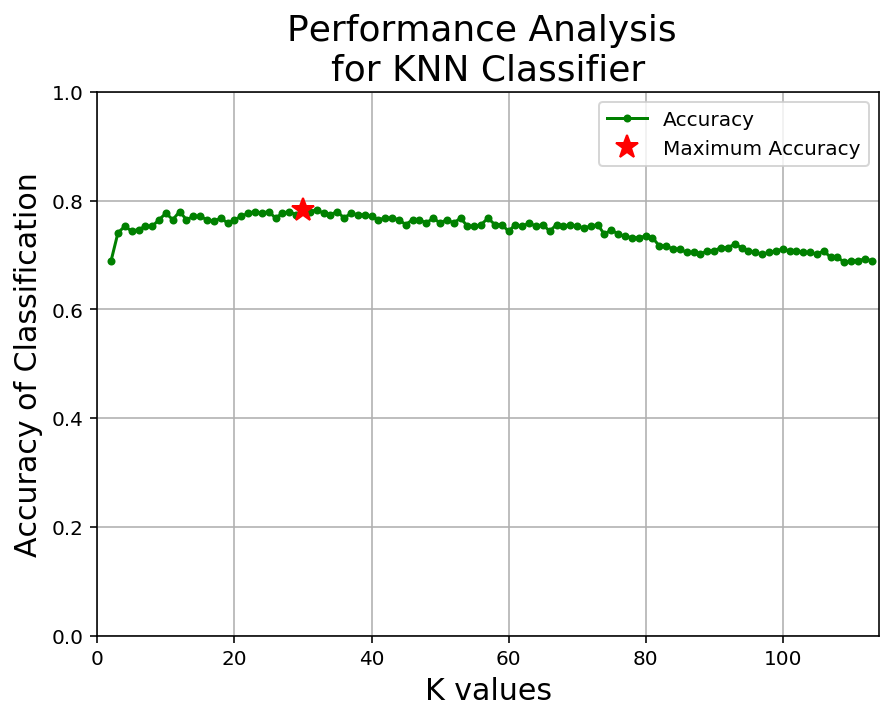

In [774]:
#---------------------K vs Accuracy plot for Performance Evaluation-------
accuracy_KNN_list=[]
K=np.arange(2, 114, 1)
for j in K:
    accu_KNN=testbool+KNNbool(j, alpha0[11],  alpha1[11]) # K=14, alpha0 and alpha 1
    uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
    caseK=dict(zip(uniqueK, countsK))
    accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
    accuracy_KNN_list.append(accuracy_KNN)
    
plt.figure(1)
plt.figure(figsize=(7,5))
plt.plot(K, accuracy_KNN_list,'g.-', label='Accuracy')
plt.plot(K[np.argmax(accuracy_KNN_list)], np.max(accuracy_KNN_list),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,114.)
plt.grid(True)
plt.xlabel('K values', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Performance Analysis \nfor KNN Classifier', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## Overall Accuracy Calculation

In [831]:
accu_case1=testbool+boolcase1
accu_case2=testbool+boolcase2
accu_case3=testbool+boolcase3
accu_KNN=testbool+KNNbool(14, alpha0[11], alpha1[11])

unique1, counts1 = np.unique(accu_case1, return_counts=True)
case1=dict(zip(unique1, counts1))

unique2, counts2 = np.unique(accu_case2, return_counts=True)
case2=dict(zip(unique2, counts2))

unique3, counts3 = np.unique(accu_case3, return_counts=True)
case3=dict(zip(unique3, counts3))

uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
caseK=dict(zip(uniqueK, countsK))

accuracy_case1= (counts1[0]+counts1[2])/(counts1[0]+counts1[1]+counts1[2])
accuracy_case2= (counts2[0]+counts2[2])/(counts2[0]+counts2[1]+counts2[2])
accuracy_case3= (counts3[0]+counts3[2])/(counts3[0]+counts3[1]+counts3[2])
accuracy_caseK= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])

print('Case 1: Overall Accuracy = ' + str(accuracy_case1) + '\n' + 'Case 2: Overall Accuracy = ' + str(accuracy_case2) + '\n'+ 'Case 3: Overall Accuracy = ' + str(accuracy_case3)+ '\n'+ 'KNN: Overall Accuracy = ' + str(accuracy_KNN))

Case 1: Overall Accuracy = 0.7710843373493976
Case 2: Overall Accuracy = 0.8042168674698795
Case 3: Overall Accuracy = 0.7650602409638554
KNN: Overall Accuracy = 0.7710843373493976


## Performance Case-1

<Figure size 432x288 with 0 Axes>

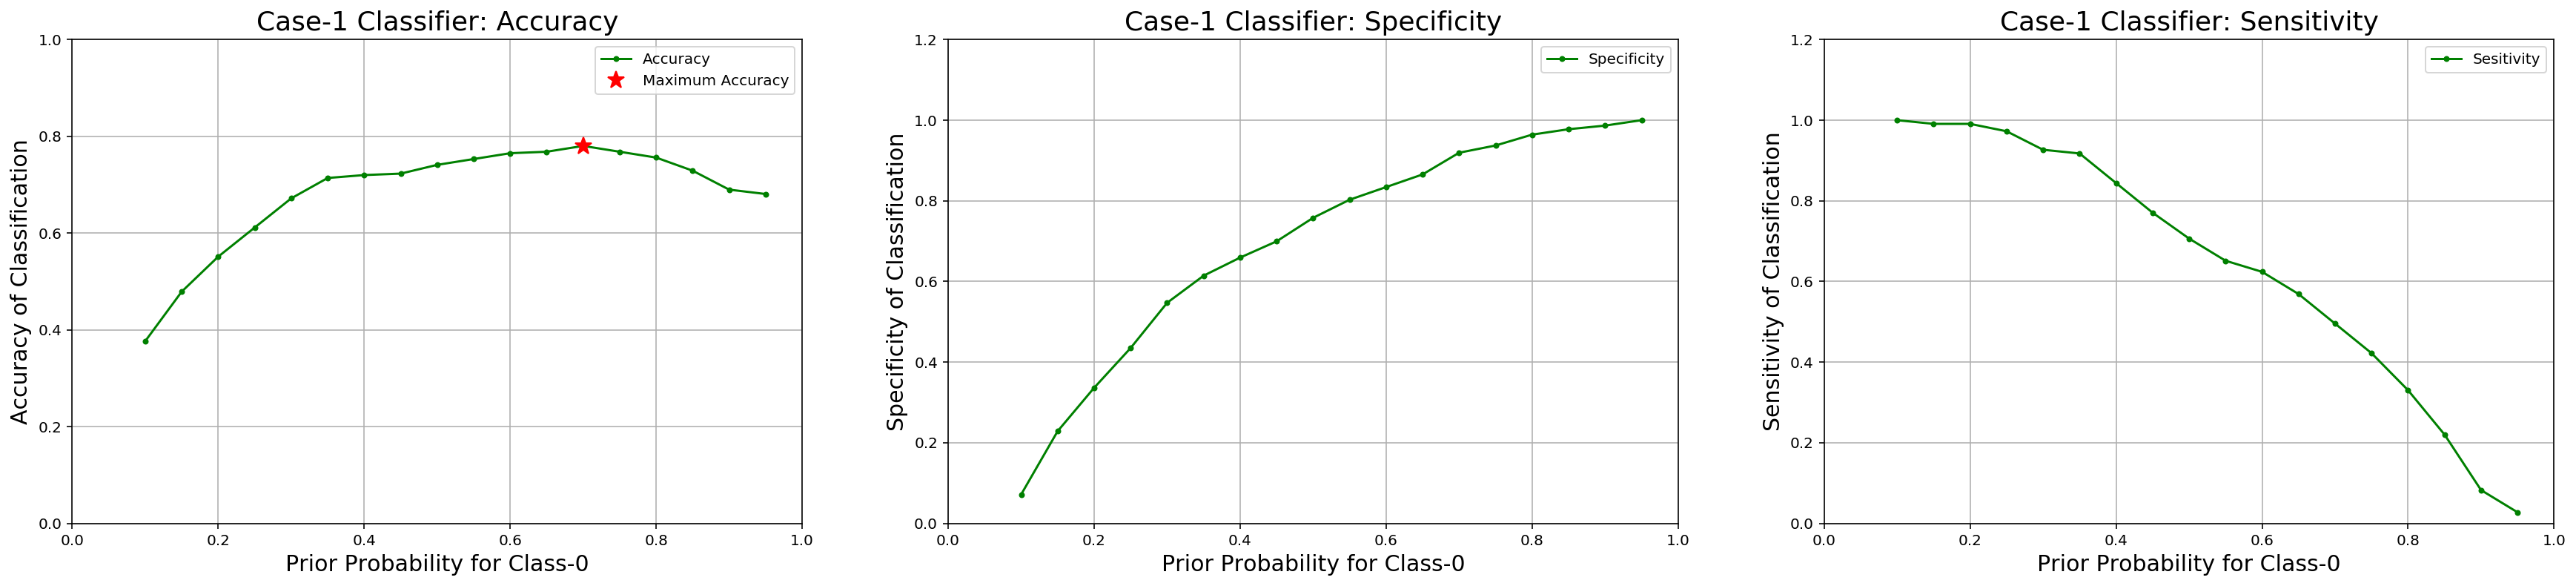

In [775]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)

sig=np.sum((sigma0+sigma1).diagonal())/7.0
sigma=sig*(np.identity(7, dtype=float))
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case1=[]
specif_case1=[]
sensit_case1=[]

pri=np.arange(0.1, 1., 0.05)
for prior in pri:
    boolcase1=g0(nXtest,prior)<=g1(nXtest,1.0-prior)
    boolcase1=np.array([1 if i else 0 for i in boolcase1])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
    accu_case1=testbool+boolcase1
    unique1, counts1 = np.unique(accu_case1, return_counts=True)
    case1=dict(zip(unique1, counts1))
    accuracy_case1= (counts1[0]+counts1[2])/(counts1[0]+counts1[1]+counts1[2])
    perfo_case1.append(accuracy_case1)

#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case1_neg=testbool-boolcase1
    tes=zip(accu_case1, accu_case1_neg)
    
    TP1=0
    TN1=0
    FP1=0
    FN1=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP1=TP1+1
        if plus==0 and minus==0:
            TN1=TN1+1
        if plus==1 and minus==-1:
            FP1=FP1+1
        if plus==1 and minus==1:
            FN1=FN1+1    
    specif_case1.append(TN1/(TN1+FP1))
    sensit_case1.append(TP1/(TP1+FN1))
    
    
plt.figure(1)
plt.figure(figsize=(30,6))

plt.subplot(131)
plt.plot(pri, perfo_case1,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case1)], np.max(perfo_case1),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-1 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case1,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case1)], np.max(specif_case1),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-1 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case1,'g.-', label='Sesitivity')
# plt.plot(pri[np.argmax(sensit_case1)], np.max(sensit_case1),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-1 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## Performance Case-2

<Figure size 432x288 with 0 Axes>

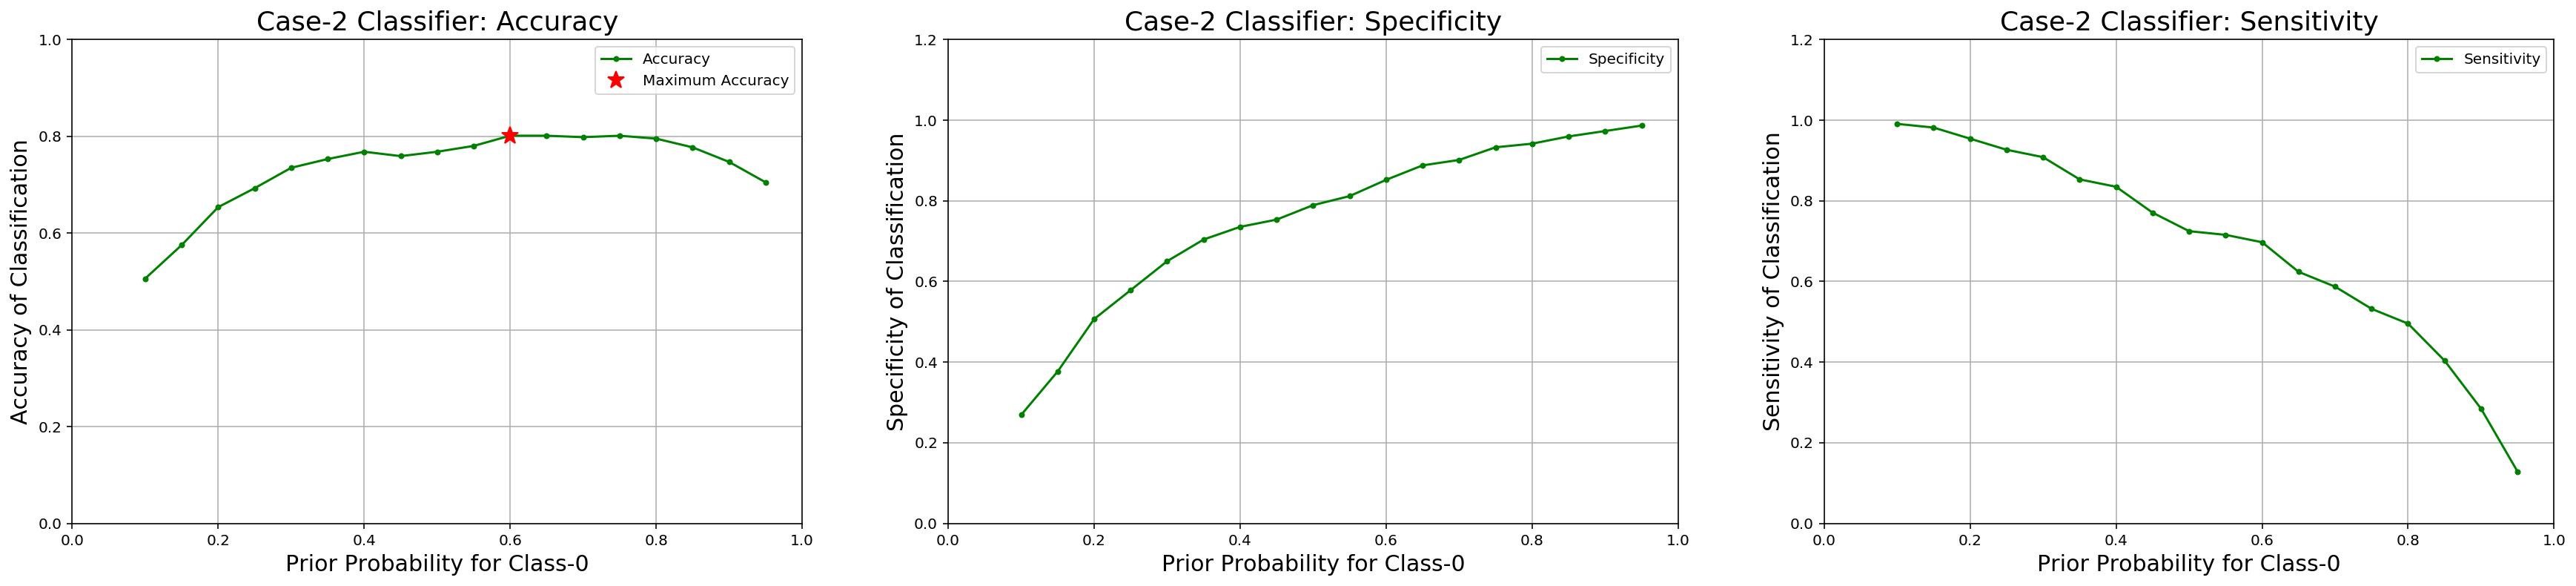

In [776]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)

sigma=(sigma0+sigma1)/2.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case2=[]
specif_case2=[]
sensit_case2=[]

pri=np.arange(0.1, 1., 0.05)
for prior in pri:
    boolcase2=g0(nXtest, prior) <= g1(nXtest, 1.0-prior)
    boolcase2=np.array([1 if i else 0 for i in boolcase2])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
    accu_case2=testbool+boolcase2
    unique2, counts2 = np.unique(accu_case2, return_counts=True)
    case2=dict(zip(unique2, counts2))
    accuracy_case2= (counts2[0]+counts2[2])/(counts2[0]+counts2[1]+counts2[2])
    perfo_case2.append(accuracy_case2)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case2_neg=testbool-boolcase2
    tes=zip(accu_case2, accu_case2_neg)
    
    TP2=0
    TN2=0
    FP2=0
    FN2=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP2=TP2+1
        if plus==0 and minus==0:
            TN2=TN2+1
        if plus==1 and minus==-1:
            FP2=FP2+1
        if plus==1 and minus==1:
            FN2=FN2+1    
    specif_case2.append(TN2/(TN2+FP2))
    sensit_case2.append(TP2/(TP2+FN2))
    
    
plt.figure(1)
plt.figure(figsize=(30,6))

plt.subplot(131)
plt.plot(pri, perfo_case2,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case2)], np.max(perfo_case2),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-2 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case2,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case2)], np.max(specif_case2),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-2 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case2,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_case2)], np.max(sensit_case2),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-2 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## Performance Case-3

<Figure size 432x288 with 0 Axes>

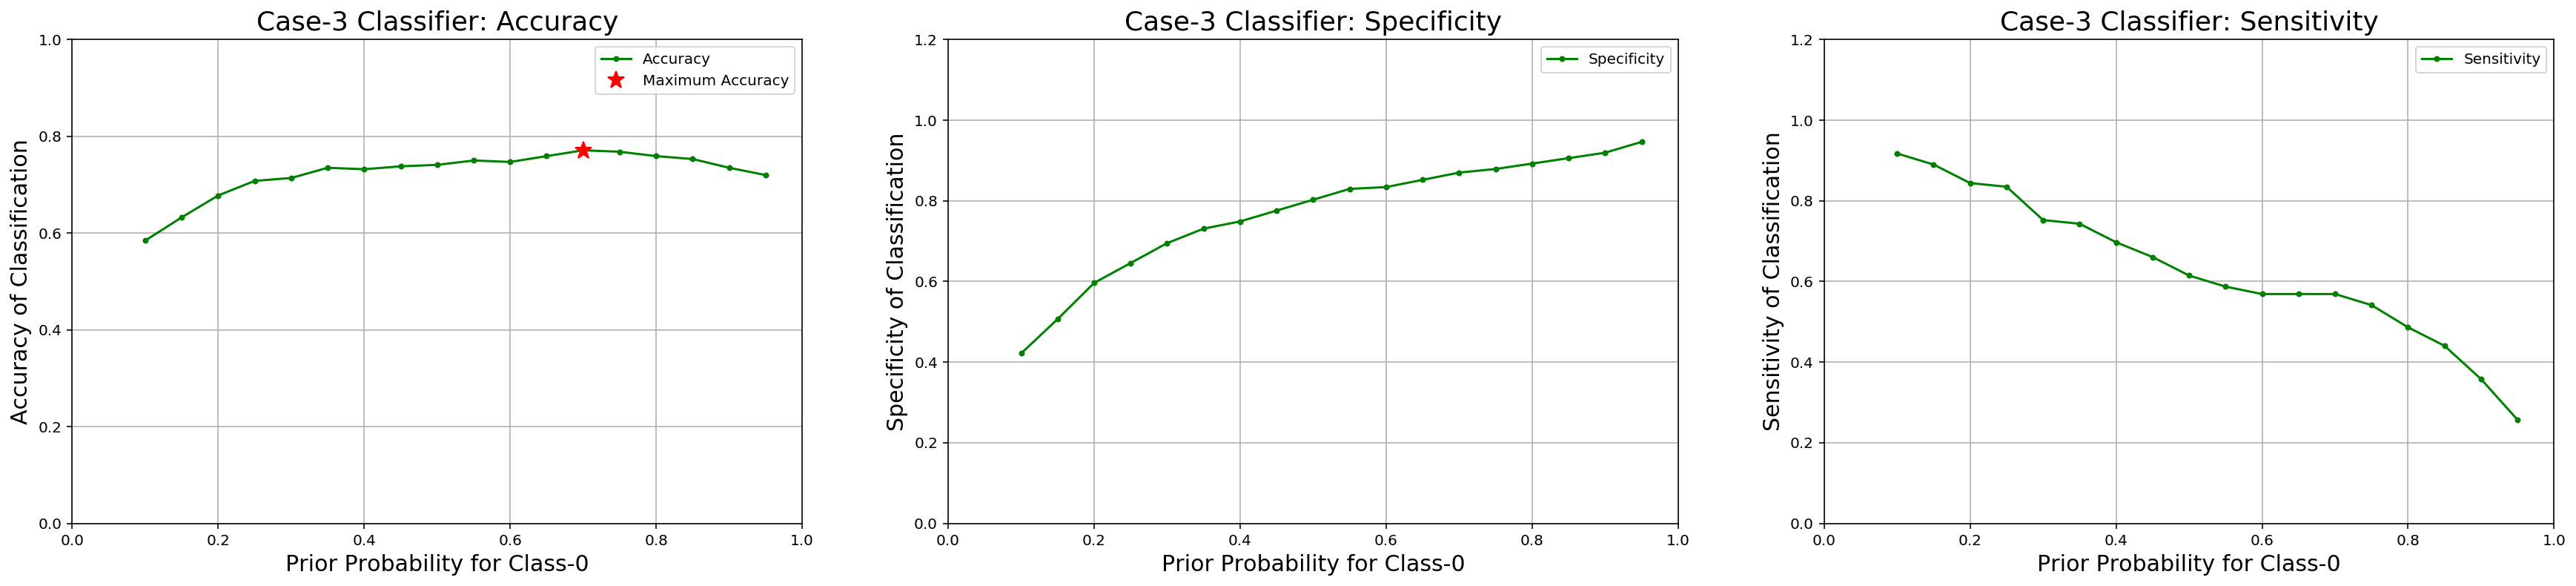

In [777]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case3=[]
specif_case3=[]
sensit_case3=[]
pri=np.arange(0.1, 1., 0.05)
for prior in pri:
    boolcase3=g0(nXtest, prior)<=g1(nXtest, 1.0-prior) # True if the sample belongs to class-0, False otherwise
    boolcase3=np.array([1 if i else 0 for i in boolcase3])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.    
    accu_case3=testbool+boolcase3
    unique3, counts3 = np.unique(accu_case3, return_counts=True)
    case3=dict(zip(unique3, counts3))
    accuracy_case3= (counts3[0]+counts3[2])/(counts3[0]+counts3[1]+counts3[2])
    perfo_case3.append(accuracy_case3)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case3_neg=testbool-boolcase3
    tes=zip(accu_case3, accu_case3_neg)
    
    TP3=0
    TN3=0
    FP3=0
    FN3=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP3=TP3+1
        if plus==0 and minus==0:
            TN3=TN3+1
        if plus==1 and minus==-1:
            FP3=FP3+1
        if plus==1 and minus==1:
            FN3=FN3+1    
    specif_case3.append(TN3/(TN3+FP3))
    sensit_case3.append(TP3/(TP3+FN3))
    
    
plt.figure(1)
plt.figure(figsize=(30,6))

plt.subplot(131)
plt.plot(pri, perfo_case3,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case3)], np.max(perfo_case3),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-3 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case3,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case3)], np.max(specif_case3),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-3 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case3,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_case3)], np.max(sensit_case3),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-3 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## Performance KNN

<Figure size 432x288 with 0 Axes>

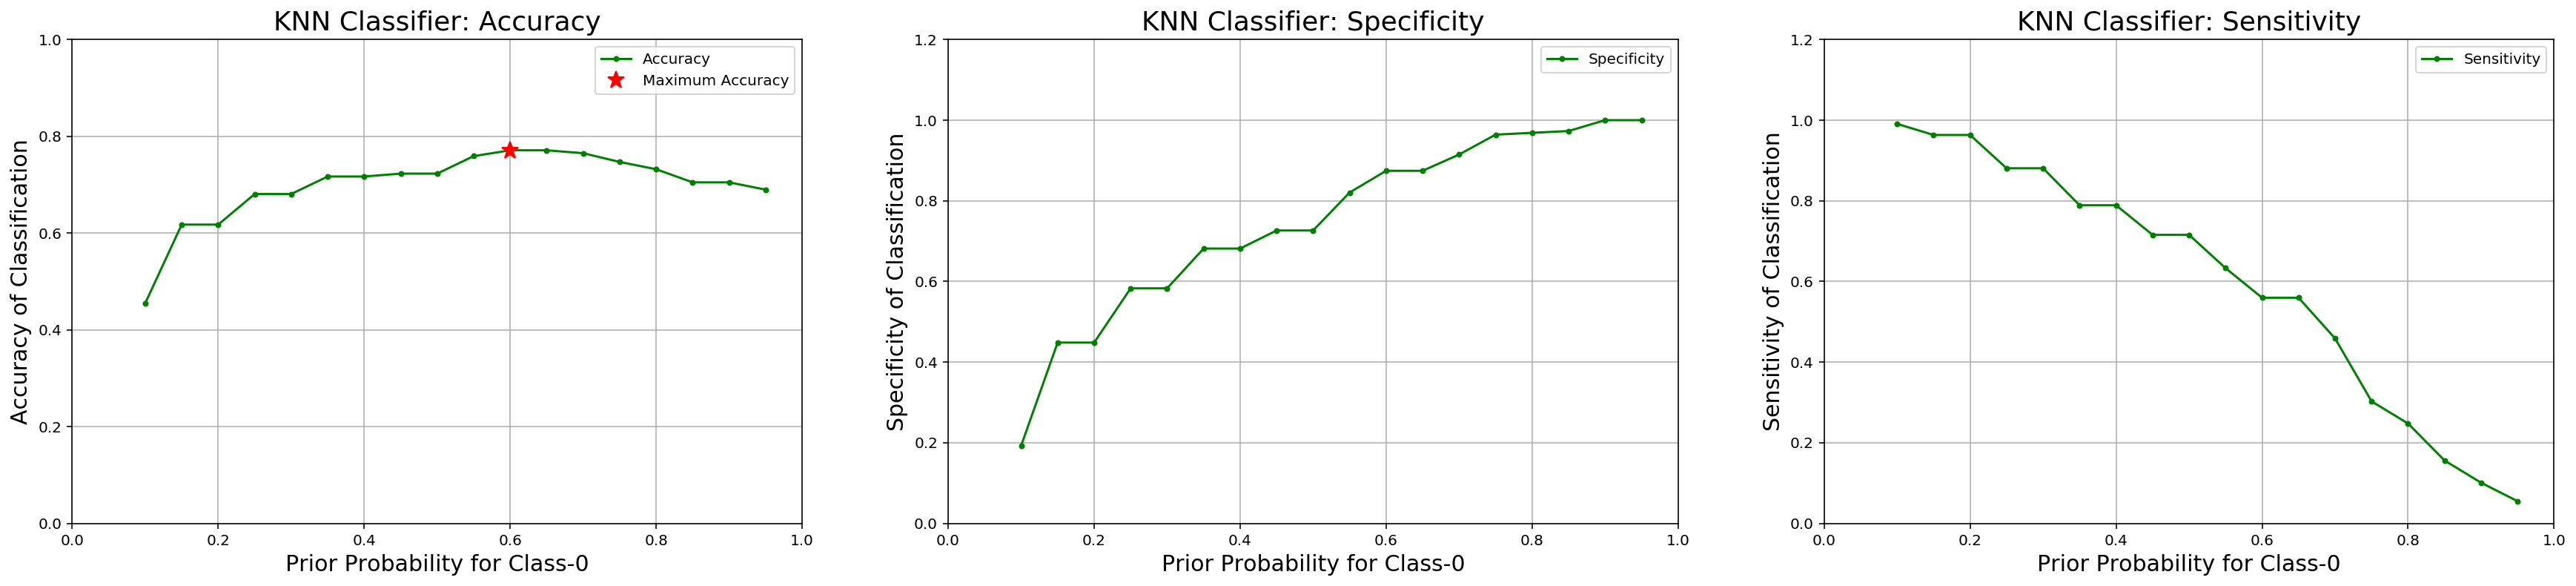

In [778]:
P0=np.arange(0.1, 1., 0.05)  # Prior values for class 0
P1=1-P0                        # Prior values for class 1
alpha0=P0/0.66                 # Alpha values for class 0
alpha1=P1/0.34                 # Alpha values for class 1

#-----------------------------------Accuracy Calculation for KNN------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_KNN=[]
specif_KNN=[]
sensit_KNN=[]

for i in range(len(alpha0)):
    accu_KNN=testbool+KNNbool(14, alpha0[i],  alpha1[i]) # K=14, alpha0 and alpha 1
    uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
    caseK=dict(zip(uniqueK, countsK))
    accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
    perfo_KNN.append(accuracy_KNN)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------  
    accu_KNN_neg=testbool-KNNbool(14, alpha0[i],  alpha1[i])
    tes=zip(accu_KNN, accu_KNN_neg)

    TPK=0
    TNK=0
    FPK=0
    FNK=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TPK=TPK+1
        if plus==0 and minus==0:
            TNK=TNK+1
        if plus==1 and minus==-1:
            FPK=FPK+1
        if plus==1 and minus==1:
            FNK=FNK+1    
    specif_KNN.append(TNK/(TNK+FPK))
    sensit_KNN.append(TPK/(TPK+FNK))

plt.figure(1)
plt.figure(figsize=(30,6))

plt.subplot(131)
plt.plot(pri, perfo_KNN,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_KNN)], np.max(perfo_KNN),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('KNN Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_KNN,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_KNN)], np.max(specif_KNN),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('KNN Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_KNN,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_KNN)], np.max(sensit_KNN),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('KNN Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()


# Task 5.2

In [789]:
classwise=np.insert(pX, 5, Xtype, axis=1)#, axis=0) # Adding the type to the distance
classwise=pd.DataFrame(classwise)
classwise.rename(columns={5:"type"}, inplace=True)

pX0=np.array(classwise[classwise['type']==0.0].drop(columns='type')) # Class separated, for FLD and kNN
pX1=np.array(classwise[classwise['type']==1.0].drop(columns='type')) # Class separated, for FLD and kNN

## Case-1 : $\Sigma_1$ = $\Sigma_2$= $\sigma^2I$

In [790]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)

sig=np.sum((sigma0+sigma1).diagonal())/5.0 # Number of features = 5
sigma=sig*(np.identity(5, dtype=float))    # Number of features = 5
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

boolcase1=g0(pXtest,0.66)<=g1(pXtest,0.34)
boolcase1=np.array([1 if i else 0 for i in boolcase1])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case1=testbool+boolcase1
unique1, counts1 = np.unique(accu_case1, return_counts=True)
case1=dict(zip(unique1, counts1))

# print('Case 1 = ' + str(case1))
accuracy_case1= (counts1[0]+counts1[2])/(counts1[0]+counts1[1]+counts1[2])
print('Case 1 PCA:\n\nOverall Accuracy = ' + str(accuracy_case1))


#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case1_neg=testbool-boolcase1
tes=zip(accu_case1, accu_case1_neg)

TP1=0
TN1=0
FP1=0
FN1=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP1=TP1+1
    if plus==0 and minus==0:
        TN1=TN1+1
    if plus==1 and minus==-1:
        FP1=FP1+1
    if plus==1 and minus==1:
        FN1=FN1+1    
        
print('TP = ' + str(TP1) + '\n' + 'TN = ' + str(TN1) + '\n'+ 'FP = ' + str(FP1)+ '\n'+ 'FN = ' + str(FN1))


Case 1 PCA:

Overall Accuracy = 0.7469879518072289
TP = 45
TN = 203
FP = 20
FN = 64


## Case-2 : $\Sigma_1$ $=$ $\Sigma_2$

In [791]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)

sigma=(sigma0+sigma1)/2.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

boolcase2=g0(pXtest,0.66) <= g1(pXtest,0.34)
boolcase2=np.array([1 if i else 0 for i in boolcase2])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case2=testbool+boolcase2
unique2, counts2 = np.unique(accu_case2, return_counts=True)
case2=dict(zip(unique2, counts2))

accuracy_case2= (counts2[0]+counts2[2])/(counts2[0]+counts2[1]+counts2[2])
print('Case 2 PCA:\n\nOverall Accuracy = ' + str(accuracy_case2))

#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case2_neg=testbool-boolcase2
tes=zip(accu_case2, accu_case2_neg)

TP2=0
TN2=0
FP2=0
FN2=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP2=TP2+1
    if plus==0 and minus==0:
        TN2=TN2+1
    if plus==1 and minus==-1:
        FP2=FP2+1
    if plus==1 and minus==1:
        FN2=FN2+1    
        
print('TP = ' + str(TP2) + '\n' + 'TN = ' + str(TN2) + '\n'+ 'FP = ' + str(FP2)+ '\n'+ 'FN = ' + str(FN2))


Case 2 PCA:

Overall Accuracy = 0.7801204819277109
TP = 59
TN = 200
FP = 23
FN = 50


## Case-3 : $\Sigma_1$ $\neq$ $\Sigma_2$

In [792]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1


boolcase3=g0(pXtest,0.66)<=g1(pXtest,0.34) # True if the sample belongs to class-0, False otherwise
boolcase3=np.array([1 if i else 0 for i in boolcase3])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case3=testbool+boolcase3
unique3, counts3 = np.unique(accu_case3, return_counts=True)
case3=dict(zip(unique3, counts3))

# print('Case 3 = ' + str(case3))
accuracy_case3= (counts3[0]+counts3[2])/(counts3[0]+counts3[1]+counts3[2])
print('Case 3 PCA:\n\nOverall Accuracy = ' + str(accuracy_case3))


#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case3_neg=testbool-boolcase3
tes=zip(accu_case3, accu_case3_neg)

TP3=0
TN3=0
FP3=0
FN3=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP3=TP3+1
    if plus==0 and minus==0:
        TN3=TN3+1
    if plus==1 and minus==-1:
        FP3=FP3+1
    if plus==1 and minus==1:
        FN3=FN3+1    
        
print('TP = ' + str(TP3) + '\n' + 'TN = ' + str(TN3) + '\n'+ 'FP = ' + str(FP3)+ '\n'+ 'FN = ' + str(FN3))

Case 3 PCA:

Overall Accuracy = 0.7590361445783133
TP = 60
TN = 192
FP = 31
FN = 49


## KNN

In [793]:
dist=np.zeros((len(pX), len(pXtest)))
for i in range(len(pX)):
    for j in range(len(pXtest)):
        dist[i][j]=np.sqrt(sum([(a - b)**2 for a, b in zip(pX[i], pXtest[j])]))
        
dist=np.insert(dist,len(pXtest),Xtype, axis=1) # Adding the type to the distance
distance=pd.DataFrame(dist)

def KNN(k, i, alpha0, alpha1):
    aa=distance.sort_values(by=[i])[len(pXtest)][:k].value_counts()
    if aa.shape==(1,):
        result=aa.keys()[0]
    elif aa.shape==(2,):
        if alpha0*aa[0]>=alpha1*aa[1]:
            result=0.0
        else:
            result=1.0
    return result

def KNNbool(k, alpha0, alpha1):
    ktype=np.zeros_like(Xtestype)
    for i in range(len(pXtest)):
        ktype[i]=KNN(k,i,alpha0,alpha1)
    return ktype

In [794]:
P0=np.arange(0.1, 1., 0.05)  # Prior values for class 0
P1=1-P0                        # Prior values for class 1
alpha0=P0/0.66                 # Alpha values for class 0
alpha1=P1/0.34                 # Alpha values for class 1

#-----------------------------------Accuracy Calculation for KNN------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

accu_KNN=testbool+KNNbool(15, alpha0[11],  alpha1[11]) # K=14, alpha0 and alpha 1
uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
caseK=dict(zip(uniqueK, countsK))

# print('Case 3 = ' + str(case3))
accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
print('KNN PCA: Overall Accuracy (K=15) = ' + str(accuracy_KNN))

#-----------------------Finding TP, TN, FP and FN---------------------------
accu_KNN_neg=testbool-KNNbool(15, alpha0[11],  alpha1[11])
tes=zip(accu_KNN, accu_KNN_neg)

TPK=0
TNK=0
FPK=0
FNK=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TPK=TPK+1
    if plus==0 and minus==0:
        TNK=TNK+1
    if plus==1 and minus==-1:
        FPK=FPK+1
    if plus==1 and minus==1:
        FNK=FNK+1    
        
print('TP = ' + str(TPK) + '\n' + 'TN = ' + str(TNK) + '\n'+ 'FP = ' + str(FPK)+ '\n'+ 'FN = ' + str(FNK))



KNN PCA: Overall Accuracy (K=15) = 0.7801204819277109
TP = 56
TN = 203
FP = 20
FN = 53


<Figure size 432x288 with 0 Axes>

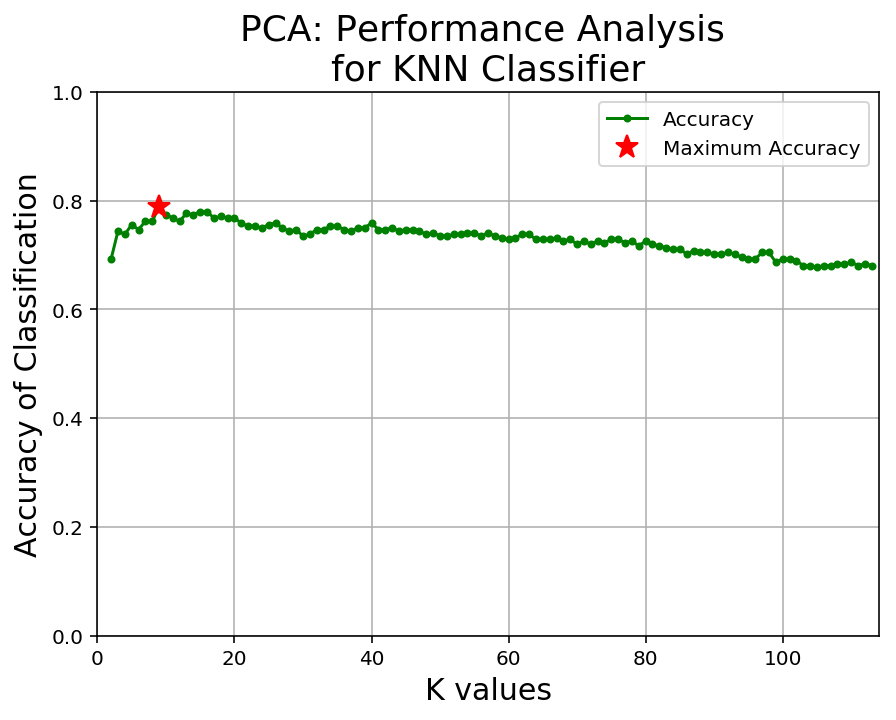

In [787]:
#---------------------K vs Accuracy plot for Performance Evaluation-------
accuracy_KNN_list=[]
K=np.arange(2, 114, 1)
for j in K:
    accu_KNN=testbool+KNNbool(j, alpha0[11],  alpha1[11]) # K=14, alpha0 and alpha 1
    uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
    caseK=dict(zip(uniqueK, countsK))
    accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
    accuracy_KNN_list.append(accuracy_KNN)
    
plt.figure(1)
plt.figure(figsize=(7,5))
plt.plot(K, accuracy_KNN_list,'g.-', label='Accuracy')
plt.plot(K[np.argmax(accuracy_KNN_list)], np.max(accuracy_KNN_list),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,114.)
plt.grid(True)
plt.xlabel('K values', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('PCA: Performance Analysis \nfor KNN Classifier', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## PCA Performance Case-1

<Figure size 432x288 with 0 Axes>

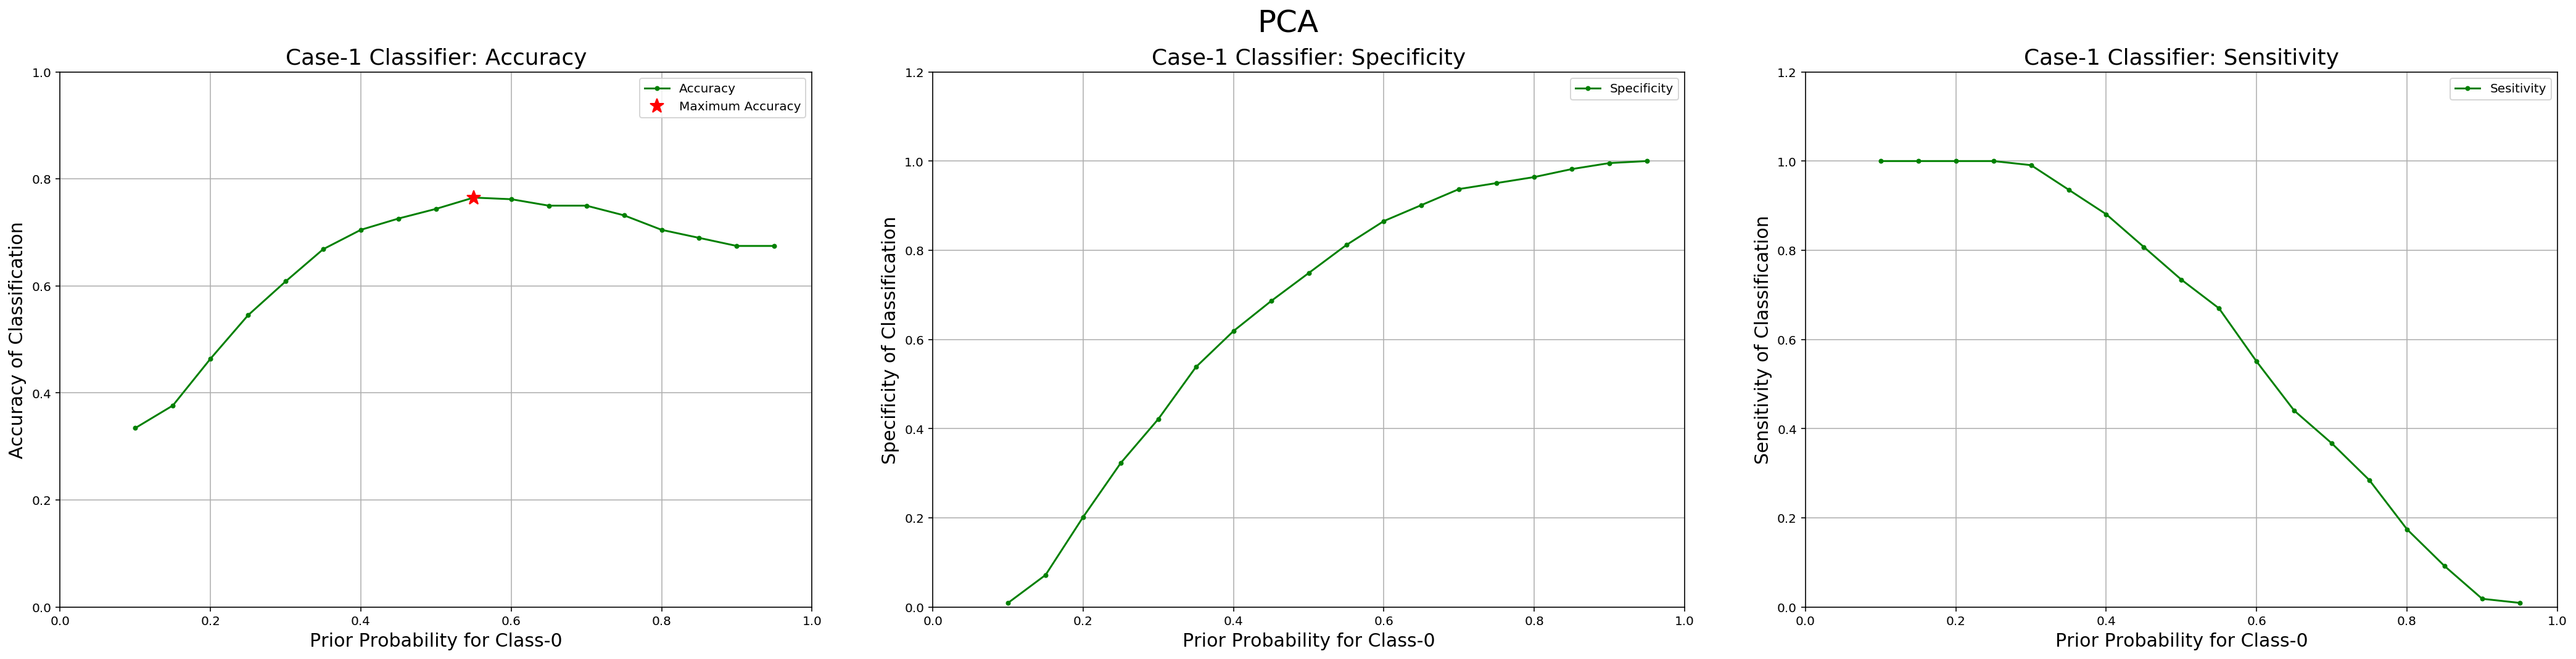

In [795]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)

sig=np.sum((sigma0+sigma1).diagonal())/5.0
sigma=sig*(np.identity(5, dtype=float))
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case1=[]
specif_case1=[]
sensit_case1=[]

pri=np.arange(0.1, 1., 0.05)
for prior in pri:
    boolcase1=g0(pXtest,prior)<=g1(pXtest,1.0-prior)
    boolcase1=np.array([1 if i else 0 for i in boolcase1])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
    accu_case1=testbool+boolcase1
    unique1, counts1 = np.unique(accu_case1, return_counts=True)
    case1=dict(zip(unique1, counts1))
    accuracy_case1= (counts1[0]+counts1[2])/(counts1[0]+counts1[1]+counts1[2])
    perfo_case1.append(accuracy_case1)

#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case1_neg=testbool-boolcase1
    tes=zip(accu_case1, accu_case1_neg)
    
    TP1=0
    TN1=0
    FP1=0
    FN1=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP1=TP1+1
        if plus==0 and minus==0:
            TN1=TN1+1
        if plus==1 and minus==-1:
            FP1=FP1+1
        if plus==1 and minus==1:
            FN1=FN1+1    
    specif_case1.append(TN1/(TN1+FP1))
    sensit_case1.append(TP1/(TP1+FN1))
    
    
plt.figure(1)
plt.figure(figsize=(30,8))
plt.suptitle("PCA", fontsize=25)
plt.subplot(131)
plt.plot(pri, perfo_case1,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case1)], np.max(perfo_case1),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-1 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case1,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case1)], np.max(specif_case1),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-1 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case1,'g.-', label='Sesitivity')
# plt.plot(pri[np.argmax(sensit_case1)], np.max(sensit_case1),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-1 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout(pad=4.3, w_pad=4.8, h_pad=2.)
plt.show()

## Performance Case-2

<Figure size 432x288 with 0 Axes>

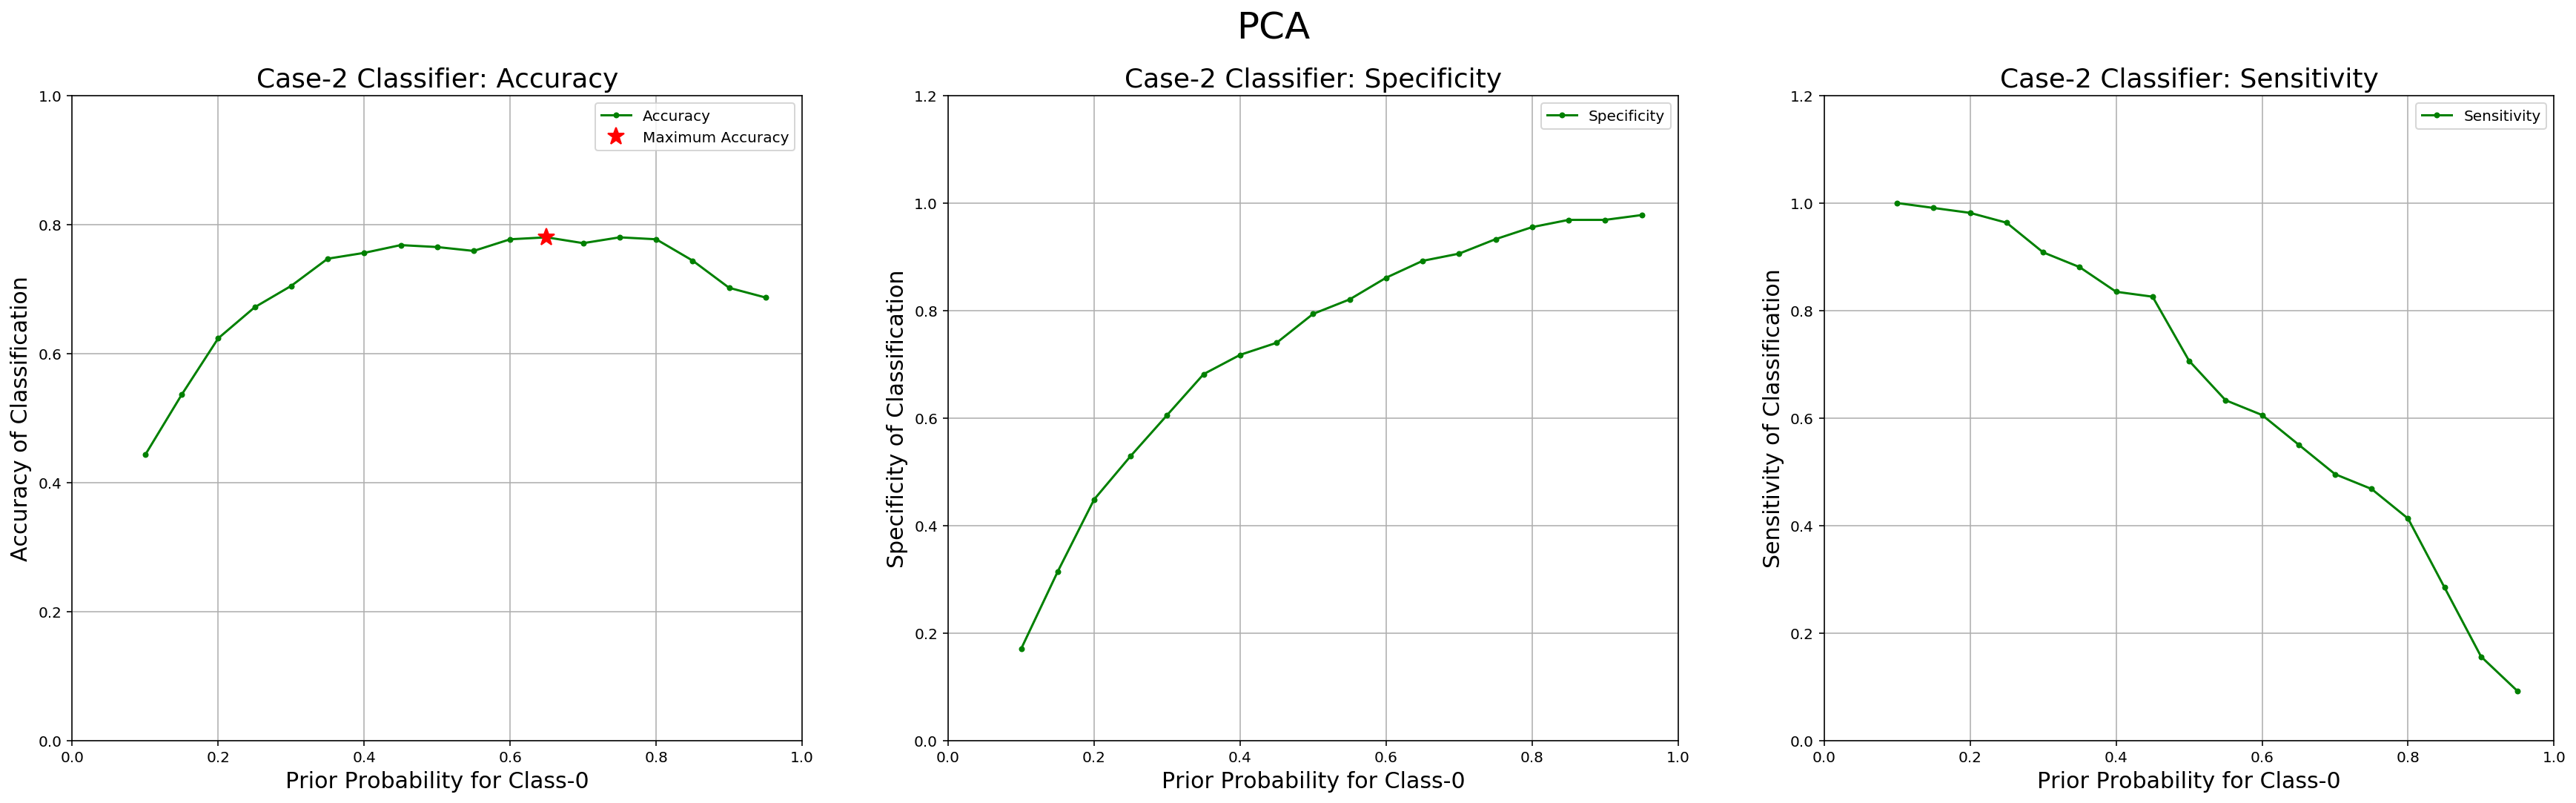

In [796]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)

sigma=(sigma0+sigma1)/2.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case2=[]
specif_case2=[]
sensit_case2=[]

pri=np.arange(0.1, 1., 0.05)
for prior in pri:
    boolcase2=g0(pXtest, prior) <= g1(pXtest, 1.0-prior)
    boolcase2=np.array([1 if i else 0 for i in boolcase2])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
    accu_case2=testbool+boolcase2
    unique2, counts2 = np.unique(accu_case2, return_counts=True)
    case2=dict(zip(unique2, counts2))
    accuracy_case2= (counts2[0]+counts2[2])/(counts2[0]+counts2[1]+counts2[2])
    perfo_case2.append(accuracy_case2)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case2_neg=testbool-boolcase2
    tes=zip(accu_case2, accu_case2_neg)
    
    TP2=0
    TN2=0
    FP2=0
    FN2=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP2=TP2+1
        if plus==0 and minus==0:
            TN2=TN2+1
        if plus==1 and minus==-1:
            FP2=FP2+1
        if plus==1 and minus==1:
            FN2=FN2+1    
    specif_case2.append(TN2/(TN2+FP2))
    sensit_case2.append(TP2/(TP2+FN2))
    
    
plt.figure(1)
plt.figure(figsize=(30,8))
plt.suptitle("PCA", fontsize=25)

plt.subplot(131)
plt.plot(pri, perfo_case2,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case2)], np.max(perfo_case2),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-2 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case2,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case2)], np.max(specif_case2),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-2 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case2,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_case2)], np.max(sensit_case2),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-2 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## Performance Case-3

<Figure size 432x288 with 0 Axes>

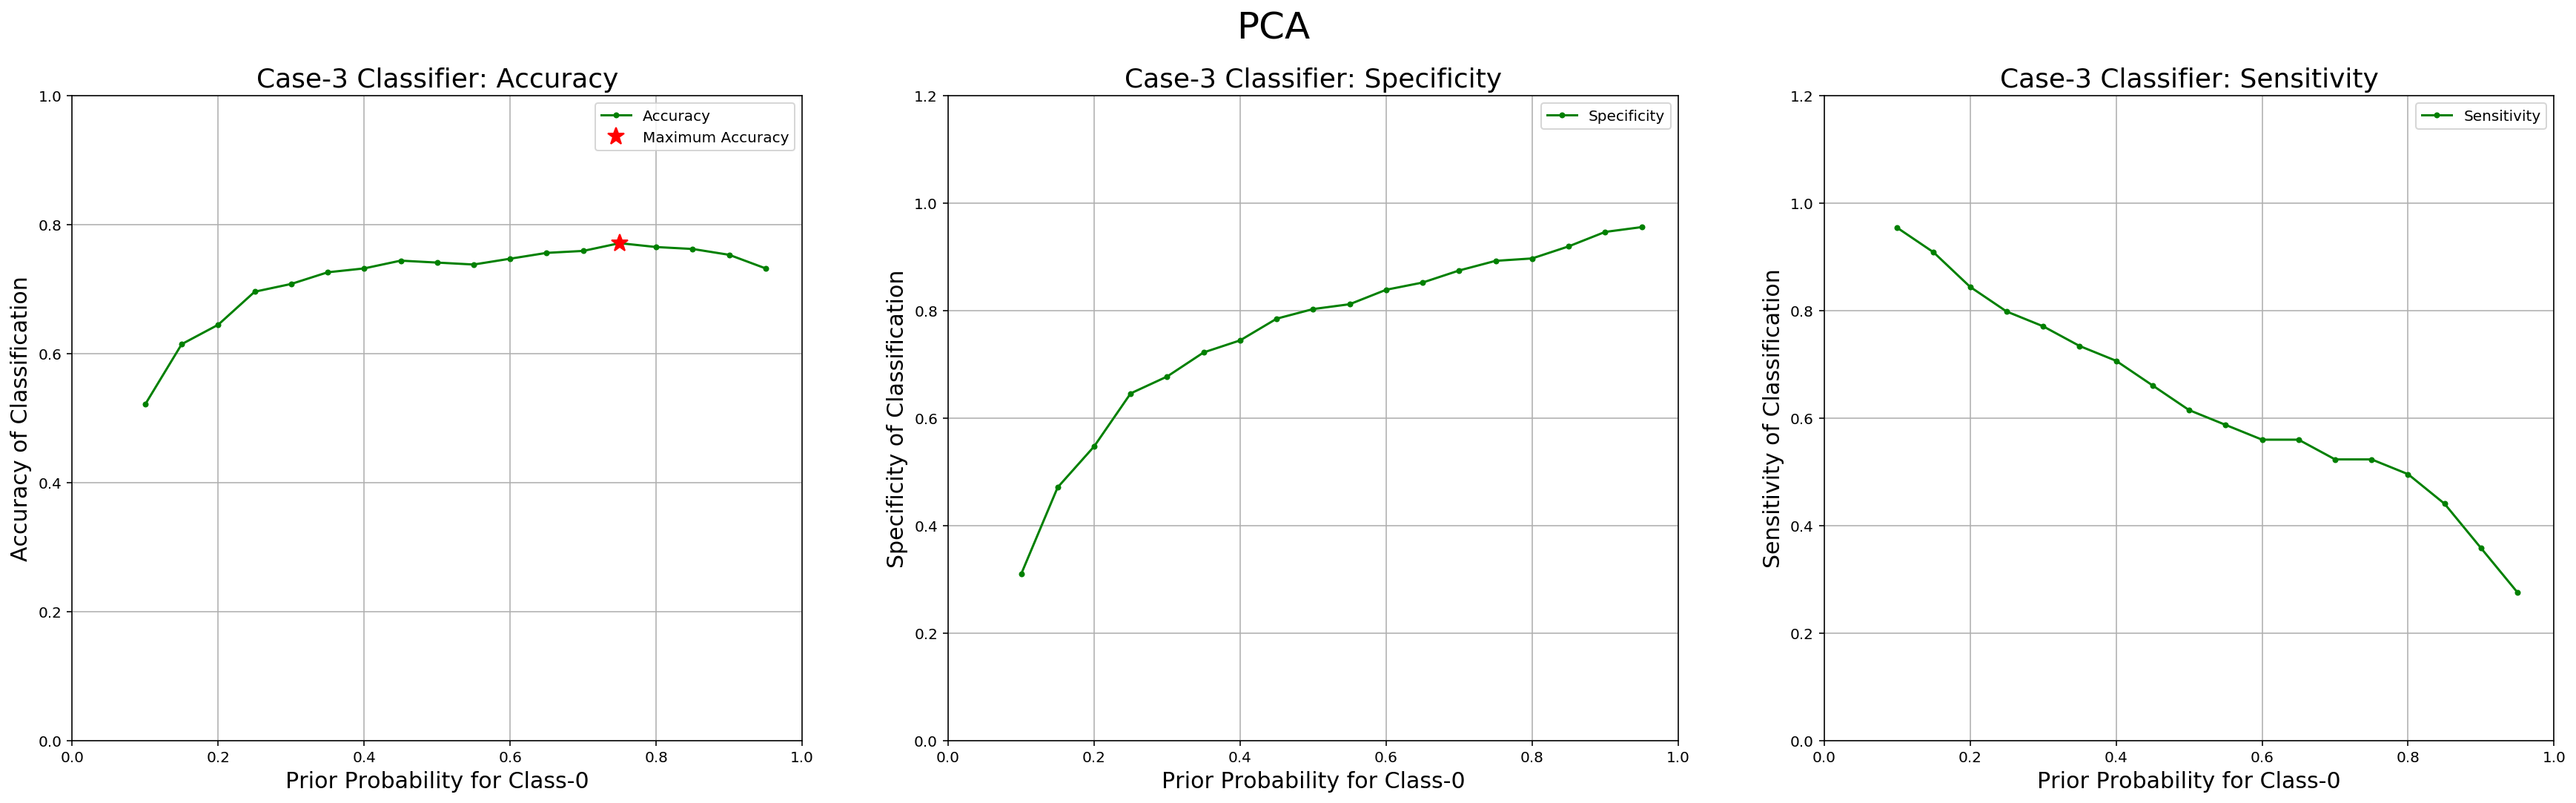

In [797]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case3=[]
specif_case3=[]
sensit_case3=[]
pri=np.arange(0.1, 1., 0.05)
for prior in pri:
    boolcase3=g0(pXtest, prior)<=g1(pXtest, 1.0-prior) # True if the sample belongs to class-0, False otherwise
    boolcase3=np.array([1 if i else 0 for i in boolcase3])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.    
    accu_case3=testbool+boolcase3
    unique3, counts3 = np.unique(accu_case3, return_counts=True)
    case3=dict(zip(unique3, counts3))
    accuracy_case3= (counts3[0]+counts3[2])/(counts3[0]+counts3[1]+counts3[2])
    perfo_case3.append(accuracy_case3)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case3_neg=testbool-boolcase3
    tes=zip(accu_case3, accu_case3_neg)
    
    TP3=0
    TN3=0
    FP3=0
    FN3=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP3=TP3+1
        if plus==0 and minus==0:
            TN3=TN3+1
        if plus==1 and minus==-1:
            FP3=FP3+1
        if plus==1 and minus==1:
            FN3=FN3+1    
    specif_case3.append(TN3/(TN3+FP3))
    sensit_case3.append(TP3/(TP3+FN3))
    
    
plt.figure(1)
plt.figure(figsize=(30,8))
plt.suptitle("PCA", fontsize=25)

plt.subplot(131)
plt.plot(pri, perfo_case3,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case3)], np.max(perfo_case3),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-3 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case3,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case3)], np.max(specif_case3),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-3 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case3,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_case3)], np.max(sensit_case3),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-3 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## Performance KNN

<Figure size 432x288 with 0 Axes>

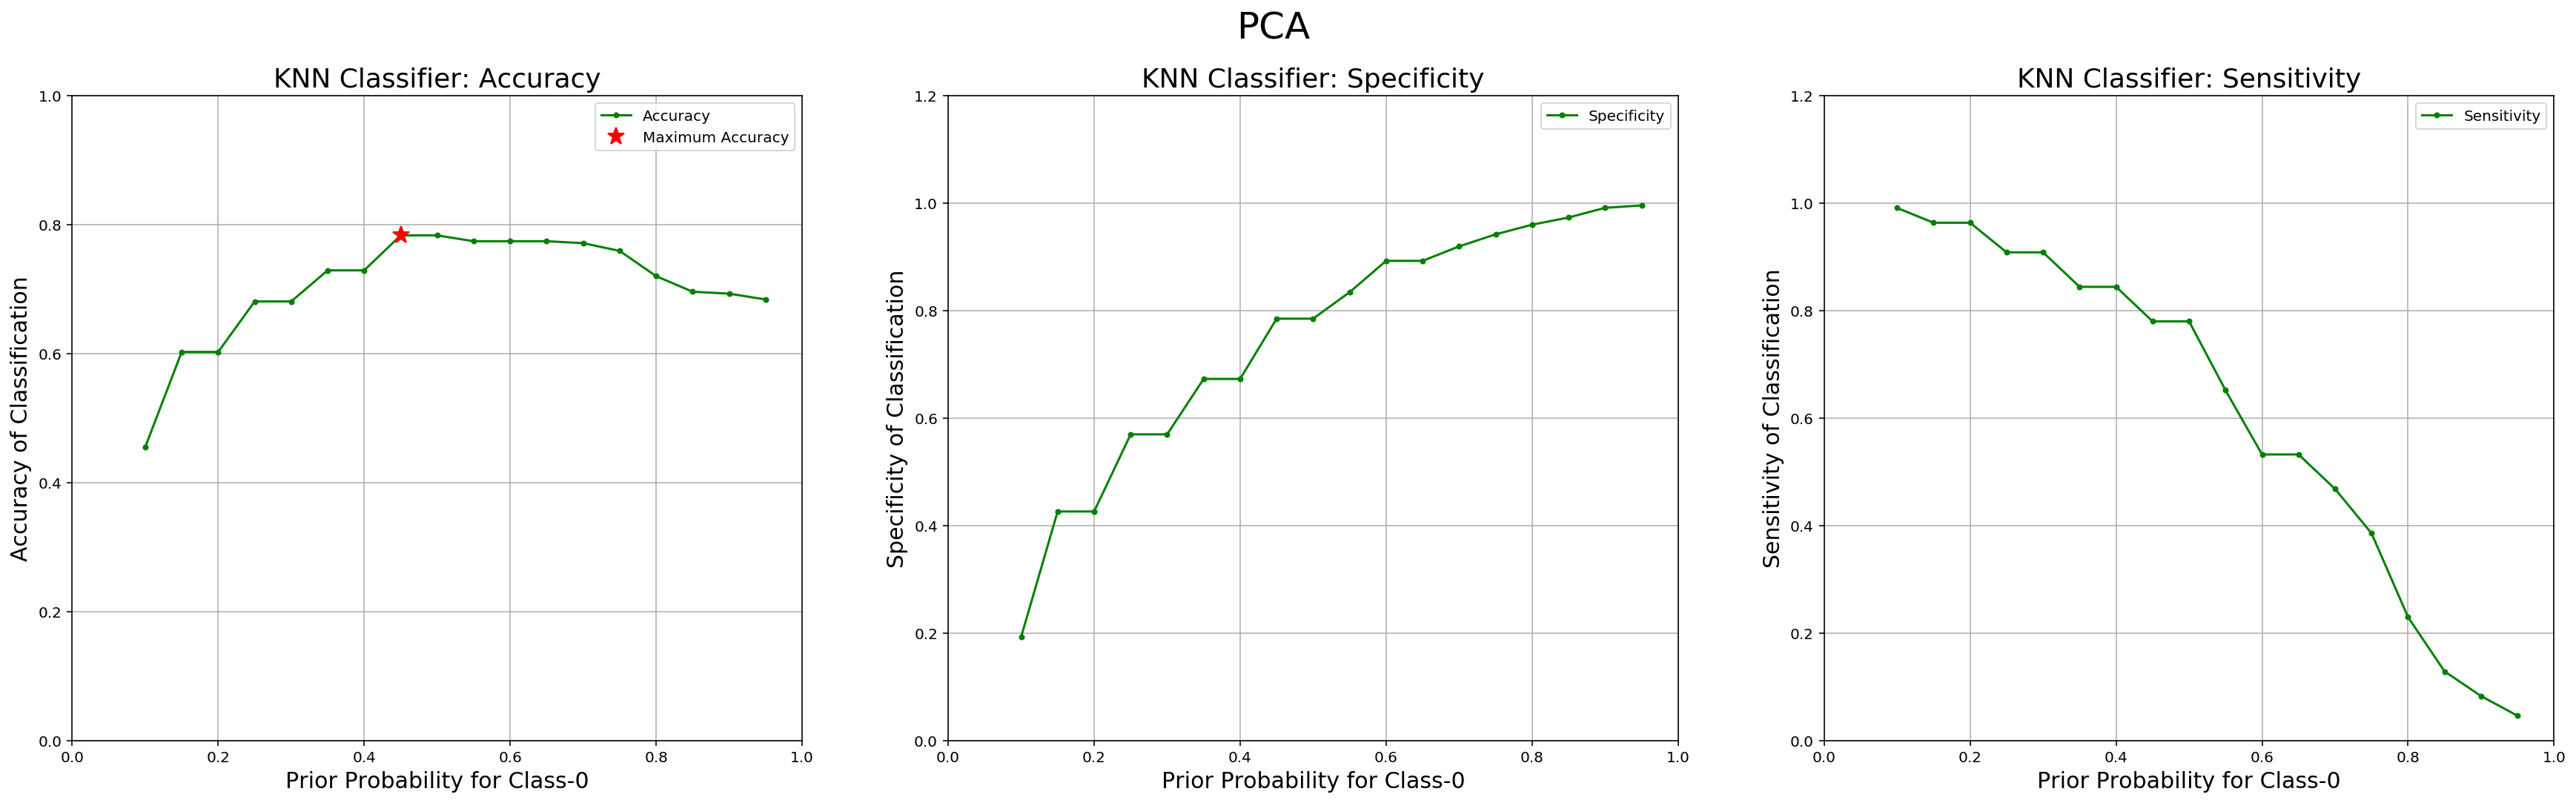

In [799]:
P0=np.arange(0.1, 1., 0.05)  # Prior values for class 0
P1=1-P0                        # Prior values for class 1
alpha0=P0/0.66                 # Alpha values for class 0
alpha1=P1/0.34                 # Alpha values for class 1

#-----------------------------------Accuracy Calculation for KNN------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_KNN=[]
specif_KNN=[]
sensit_KNN=[]

for i in range(len(alpha0)):
    accu_KNN=testbool+KNNbool(14, alpha0[i],  alpha1[i]) # K=14, alpha0 and alpha 1
    uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
    caseK=dict(zip(uniqueK, countsK))
    accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
    perfo_KNN.append(accuracy_KNN)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------  
    accu_KNN_neg=testbool-KNNbool(14, alpha0[i],  alpha1[i])
    tes=zip(accu_KNN, accu_KNN_neg)

    TPK=0
    TNK=0
    FPK=0
    FNK=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TPK=TPK+1
        if plus==0 and minus==0:
            TNK=TNK+1
        if plus==1 and minus==-1:
            FPK=FPK+1
        if plus==1 and minus==1:
            FNK=FNK+1    
    specif_KNN.append(TNK/(TNK+FPK))
    sensit_KNN.append(TPK/(TPK+FNK))

plt.figure(1)
plt.figure(figsize=(30,8))
plt.suptitle("PCA", fontsize=25)

plt.subplot(131)
plt.plot(pri, perfo_KNN,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_KNN)], np.max(perfo_KNN),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('KNN Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_KNN,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_KNN)], np.max(specif_KNN),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('KNN Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_KNN,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_KNN)], np.max(sensit_KNN),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('KNN Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()


### sensitivity and specificity curves against different error rate

In [621]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

nmu, nsigma = EstGauss(nX)

# Eigen decomposition for PCA
w, v = np.linalg.eig(nsigma)
# Ordering the eigen values from highest to lowest
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]

frac=[i/np.sum(w) for i in w]

# Determine the 'm' value for the matrix dimensions.
fraction=0.0
error=1.0-fraction
for i in range(len(frac)):
    if error>=0.10:
        fraction+=frac[i]
        error=1-fraction
        m=i

pX=np.matmul(v[:m+1,:], nX.transpose())  # The multiplication of the principal axes to transform the data.
pX=pX.transpose()

pXtest=np.matmul(v[:m+1,:], nXtest.transpose())  # The multiplication of the principal axes to transform the data.
pXtest=pXtest.transpose()

Only 5 features are needed for PCA based on the error rate out of the 7 features


# Task 5.3

In [800]:
classwise=np.insert(fX, 1, Xtype, axis=1)#, axis=0) # Adding the type to the distance
classwise=pd.DataFrame(classwise)
classwise.rename(columns={1:"type"}, inplace=True)

fX0=np.array(classwise[classwise['type']==0.0].drop(columns='type')) # Class separated, for FLD and kNN
fX1=np.array(classwise[classwise['type']==1.0].drop(columns='type')) # Class separated, for FLD and kNN

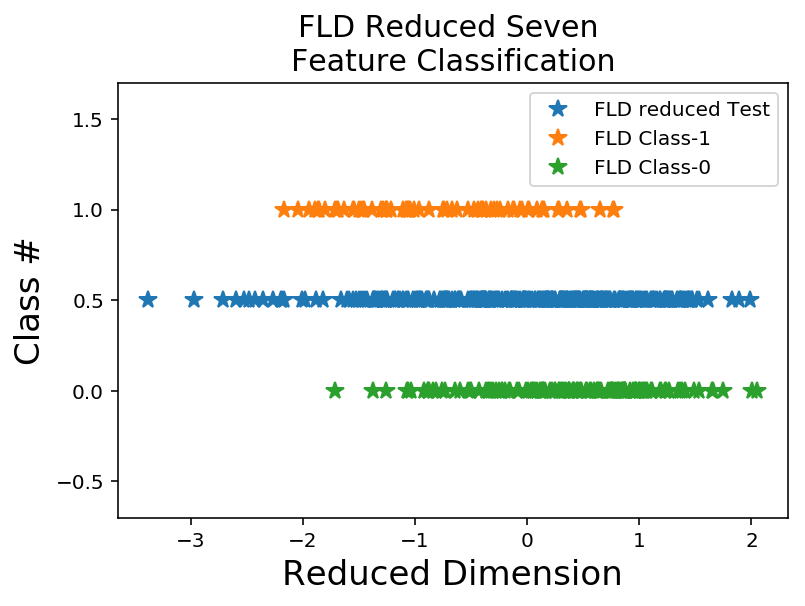

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [726]:
plt.plot(fXtest, np.full_like(fXtest, 0.5),'*',label='FLD reduced Test', markersize=9)
plt.plot(fX1, np.ones_like(fX1),'*',label='FLD Class-1', markersize=9)
plt.plot(fX0, np.zeros_like(fX0),'*',label='FLD Class-0', markersize=9)

plt.ylim(-0.7,1.7)
plt.xlabel('Reduced Dimension', fontsize=17)
plt.ylabel('Class #', fontsize=17)
plt.title('FLD Reduced Seven \nFeature Classification', fontsize=15)
plt.legend(loc='upper right')
plt.legend(loc='upper right')
plt.show()

## Case-1 : $\Sigma_1$ = $\Sigma_2$= $\sigma^2I$

In [801]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)

sig=np.sum((sigma0+sigma1).diagonal())/1.0 # Number of features = 5
sigma=sig*(np.identity(1, dtype=float))    # Number of features = 5
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

boolcase1=g0(fXtest,0.66)<=g1(fXtest,0.34)
boolcase1=np.array([1 if i else 0 for i in boolcase1])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case1=testbool+boolcase1
unique1, counts1 = np.unique(accu_case1, return_counts=True)
case1=dict(zip(unique1, counts1))

# print('Case 1 = ' + str(case1))
accuracy_case1= (counts1[0]+counts1[2])/(counts1[0]+counts1[1]+counts1[2])
print('Case 1 FLD:\n\nOverall Accuracy = ' + str(accuracy_case1))

#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case1_neg=testbool-boolcase1
tes=zip(accu_case1, accu_case1_neg)

TP1=0
TN1=0
FP1=0
FN1=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP1=TP1+1
    if plus==0 and minus==0:
        TN1=TN1+1
    if plus==1 and minus==-1:
        FP1=FP1+1
    if plus==1 and minus==1:
        FN1=FN1+1    
        
print('TP = ' + str(TP1) + '\n' + 'TN = ' + str(TN1) + '\n'+ 'FP = ' + str(FP1)+ '\n'+ 'FN = ' + str(FN1))


Case 1 FLD:

Overall Accuracy = 0.7951807228915663
TP = 54
TN = 210
FP = 13
FN = 55


## Case-2 : $\Sigma_1$ $=$ $\Sigma_2$

In [802]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)

sigma=(sigma0+sigma1)/2.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

boolcase2=g0(fXtest,0.66) <= g1(fXtest,0.34)
boolcase2=np.array([1 if i else 0 for i in boolcase2])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case2=testbool+boolcase2
unique2, counts2 = np.unique(accu_case2, return_counts=True)
case2=dict(zip(unique2, counts2))

accuracy_case2= (counts2[0]+counts2[2])/(counts2[0]+counts2[1]+counts2[2])
print('Case 2 FLD:\n\nOverall Accuracy = ' + str(accuracy_case2))

#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case2_neg=testbool-boolcase2
tes=zip(accu_case2, accu_case2_neg)

TP2=0
TN2=0
FP2=0
FN2=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP2=TP2+1
    if plus==0 and minus==0:
        TN2=TN2+1
    if plus==1 and minus==-1:
        FP2=FP2+1
    if plus==1 and minus==1:
        FN2=FN2+1    
        
print('TP = ' + str(TP2) + '\n' + 'TN = ' + str(TN2) + '\n'+ 'FP = ' + str(FP2)+ '\n'+ 'FN = ' + str(FN2))


Case 2 FLD:

Overall Accuracy = 0.8042168674698795
TP = 67
TN = 200
FP = 23
FN = 42


## Case-3 : $\Sigma_1$ $\neq$ $\Sigma_2$

In [805]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1


boolcase3=g0(fXtest,0.66)<=g1(fXtest,0.34) # True if the sample belongs to class-0, False otherwise
boolcase3=np.array([1 if i else 0 for i in boolcase3])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
accu_case3=testbool+boolcase3
unique3, counts3 = np.unique(accu_case3, return_counts=True)
case3=dict(zip(unique3, counts3))

# print('Case 3 = ' + str(case3))
accuracy_case3= (counts3[0]+counts3[2])/(counts3[0]+counts3[1]+counts3[2])
print('Case 3 FLD:\n\nOverall Accuracy = ' + str(accuracy_case3))


#-----------------------Finding TP, TN, FP and FN---------------------------
accu_case3_neg=testbool-boolcase3
tes=zip(accu_case3, accu_case3_neg)

TP3=0
TN3=0
FP3=0
FN3=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TP3=TP3+1
    if plus==0 and minus==0:
        TN3=TN3+1
    if plus==1 and minus==-1:
        FP3=FP3+1
    if plus==1 and minus==1:
        FN3=FN3+1    
        
print('TP = ' + str(TP3) + '\n' + 'TN = ' + str(TN3) + '\n'+ 'FP = ' + str(FP3)+ '\n'+ 'FN = ' + str(FN3))

Case 3 FLD:

Overall Accuracy = 0.8042168674698795
TP = 67
TN = 200
FP = 23
FN = 42


## KNN

In [806]:
dist=np.zeros((len(fX), len(fXtest)))
for i in range(len(fX)):
    for j in range(len(fXtest)):
        dist[i][j]=np.sqrt(sum([(a - b)**2 for a, b in zip(fX[i], fXtest[j])]))
        
dist=np.insert(dist,len(fXtest),Xtype, axis=1) # Adding the type to the distance
distance=pd.DataFrame(dist)

def KNN(k, i, alpha0, alpha1):
    aa=distance.sort_values(by=[i])[len(fXtest)][:k].value_counts()
    if aa.shape==(1,):
        result=aa.keys()[0]
    elif aa.shape==(2,):
        if alpha0*aa[0]>=alpha1*aa[1]:
            result=0.0
        else:
            result=1.0
    return result

def KNNbool(k, alpha0, alpha1):
    ktype=np.zeros_like(Xtestype)
    for i in range(len(fXtest)):
        ktype[i]=KNN(k,i,alpha0,alpha1)
    return ktype

In [808]:
P0=np.arange(0.1, 1., 0.05)  # Prior values for class 0
P1=1-P0                        # Prior values for class 1
alpha0=P0/0.66                 # Alpha values for class 0
alpha1=P1/0.34                 # Alpha values for class 1

#-----------------------------------Accuracy Calculation for KNN------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

accu_KNN=testbool+KNNbool(14, alpha0[11],  alpha1[11]) # K=14, alpha0 and alpha 1
uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
caseK=dict(zip(uniqueK, countsK))

# print('Case 3 = ' + str(case3))
accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
print('KNN FLD: Overall Accuracy (K=14) = ' + str(accuracy_KNN))

#-----------------------Finding TP, TN, FP and FN---------------------------
accu_KNN_neg=testbool-KNNbool(14, alpha0[11],  alpha1[11])
tes=zip(accu_KNN, accu_KNN_neg)

TPK=0
TNK=0
FPK=0
FNK=0
for plus, minus in tes:
    if plus==2 and minus==0:
        TPK=TPK+1
    if plus==0 and minus==0:
        TNK=TNK+1
    if plus==1 and minus==-1:
        FPK=FPK+1
    if plus==1 and minus==1:
        FNK=FNK+1    
        
print('TP = ' + str(TPK) + '\n' + 'TN = ' + str(TNK) + '\n'+ 'FP = ' + str(FPK)+ '\n'+ 'FN = ' + str(FNK))



KNN FLD: Overall Accuracy (K=14) = 0.7771084337349398
TP = 69
TN = 189
FP = 34
FN = 40


<Figure size 432x288 with 0 Axes>

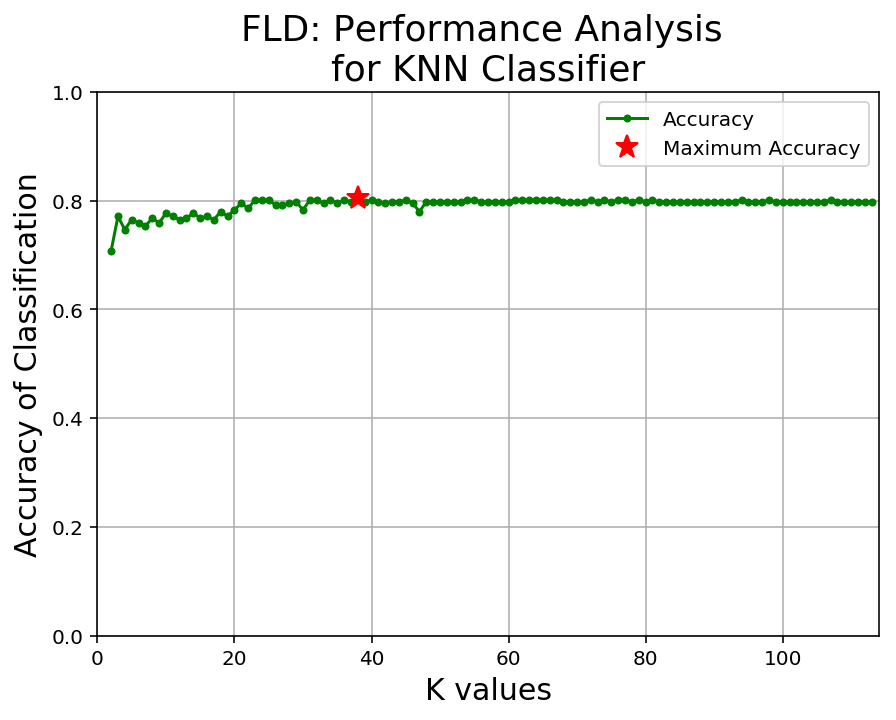

In [809]:
#---------------------K vs Accuracy plot for Performance Evaluation-------
accuracy_KNN_list=[]
K=np.arange(2, 114, 1)
for j in K:
    accu_KNN=testbool+KNNbool(j, alpha0[11],  alpha1[11]) # K=14, alpha0 and alpha 1
    uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
    caseK=dict(zip(uniqueK, countsK))
    accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
    accuracy_KNN_list.append(accuracy_KNN)
    
plt.figure(1)
plt.figure(figsize=(7,5))
plt.plot(K, accuracy_KNN_list,'g.-', label='Accuracy')
plt.plot(K[np.argmax(accuracy_KNN_list)], np.max(accuracy_KNN_list),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,114.)
plt.grid(True)
plt.xlabel('K values', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('FLD: Performance Analysis \nfor KNN Classifier', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## FLD Performance Case-1

<Figure size 432x288 with 0 Axes>

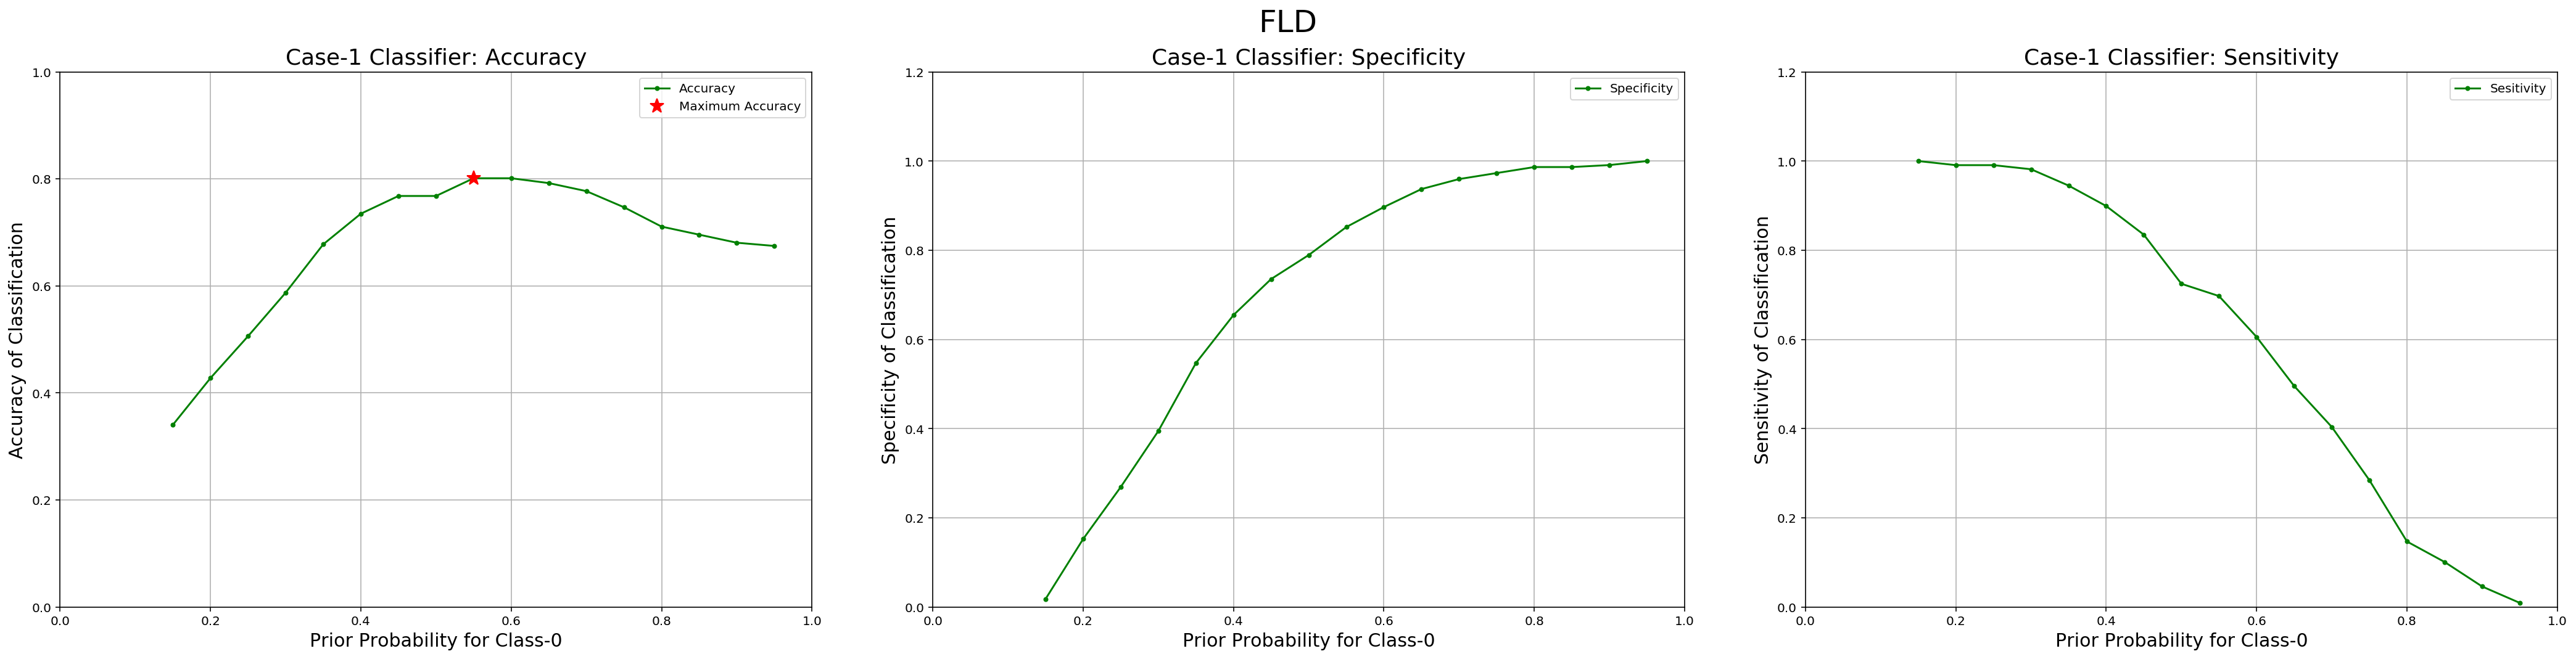

In [810]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)

sig=np.sum((sigma0+sigma1).diagonal())/1.0
sigma=sig*(np.identity(1, dtype=float))
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case1=[]
specif_case1=[]
sensit_case1=[]

pri=np.arange(0.15, 1., 0.05)
for prior in pri:
    boolcase1=g0(fXtest,prior)<=g1(fXtest,1.0-prior)
    boolcase1=np.array([1 if i else 0 for i in boolcase1])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
    accu_case1=testbool+boolcase1
    unique1, counts1 = np.unique(accu_case1, return_counts=True)
    case1=dict(zip(unique1, counts1))
    accuracy_case1= (counts1[0]+counts1[2])/(counts1[0]+counts1[1]+counts1[2])
    perfo_case1.append(accuracy_case1)

#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case1_neg=testbool-boolcase1
    tes=zip(accu_case1, accu_case1_neg)
    
    TP1=0
    TN1=0
    FP1=0
    FN1=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP1=TP1+1
        if plus==0 and minus==0:
            TN1=TN1+1
        if plus==1 and minus==-1:
            FP1=FP1+1
        if plus==1 and minus==1:
            FN1=FN1+1    
    specif_case1.append(TN1/(TN1+FP1))
    sensit_case1.append(TP1/(TP1+FN1))
    
    
plt.figure(1)
plt.figure(figsize=(30,8))
plt.suptitle("FLD", fontsize=25)
plt.subplot(131)
plt.plot(pri, perfo_case1,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case1)], np.max(perfo_case1),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-1 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case1,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case1)], np.max(specif_case1),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-1 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case1,'g.-', label='Sesitivity')
# plt.plot(pri[np.argmax(sensit_case1)], np.max(sensit_case1),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-1 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout(pad=4.3, w_pad=4.8, h_pad=2.)
plt.show()

## Performance Case-2

<Figure size 432x288 with 0 Axes>

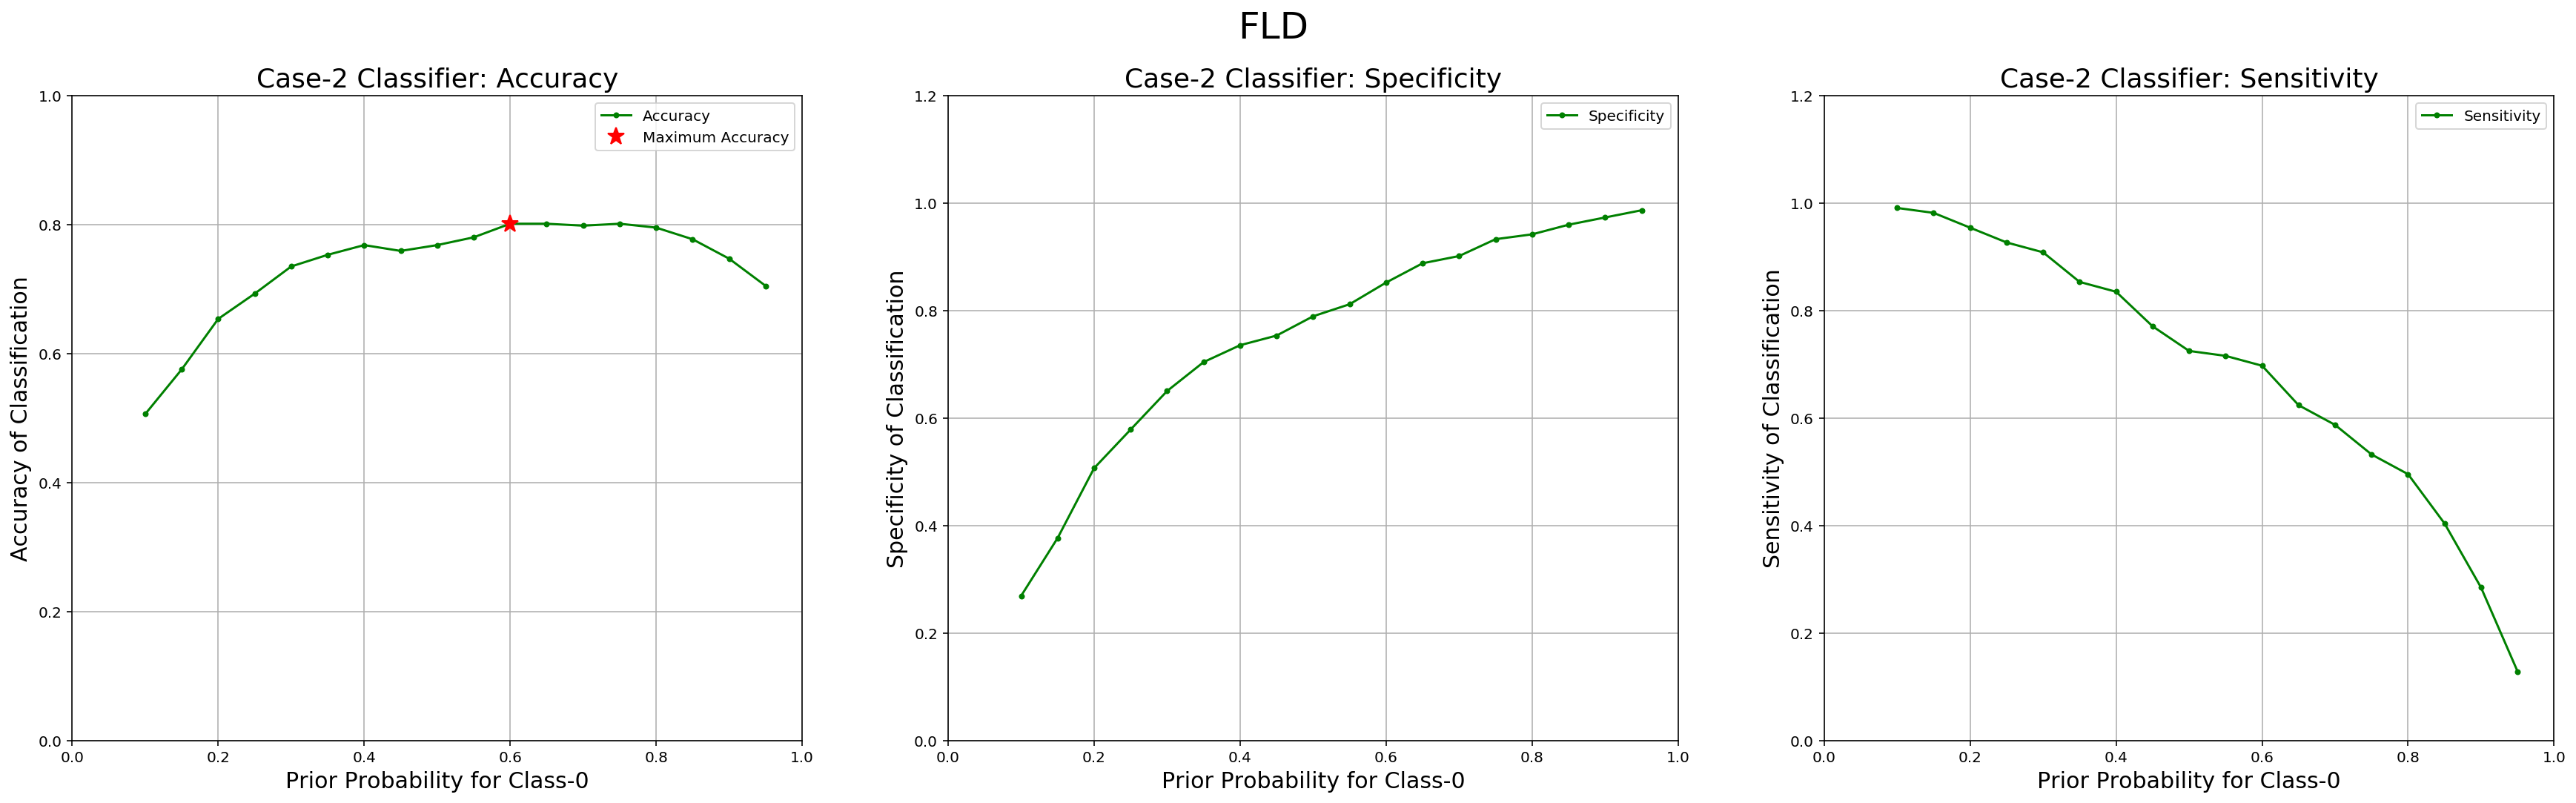

In [811]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)

sigma=(sigma0+sigma1)/2.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case2=[]
specif_case2=[]
sensit_case2=[]

pri=np.arange(0.1, 1., 0.05)
for prior in pri:
    boolcase2=g0(fXtest, prior) <= g1(fXtest, 1.0-prior)
    boolcase2=np.array([1 if i else 0 for i in boolcase2])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
    accu_case2=testbool+boolcase2
    unique2, counts2 = np.unique(accu_case2, return_counts=True)
    case2=dict(zip(unique2, counts2))
    accuracy_case2= (counts2[0]+counts2[2])/(counts2[0]+counts2[1]+counts2[2])
    perfo_case2.append(accuracy_case2)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case2_neg=testbool-boolcase2
    tes=zip(accu_case2, accu_case2_neg)
    
    TP2=0
    TN2=0
    FP2=0
    FN2=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP2=TP2+1
        if plus==0 and minus==0:
            TN2=TN2+1
        if plus==1 and minus==-1:
            FP2=FP2+1
        if plus==1 and minus==1:
            FN2=FN2+1    
    specif_case2.append(TN2/(TN2+FP2))
    sensit_case2.append(TP2/(TP2+FN2))
    
    
plt.figure(1)
plt.figure(figsize=(30,8))
plt.suptitle("FLD", fontsize=25)

plt.subplot(131)
plt.plot(pri, perfo_case2,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case2)], np.max(perfo_case2),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-2 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case2,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case2)], np.max(specif_case2),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-2 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case2,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_case2)], np.max(sensit_case2),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-2 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## Performance Case-3

<Figure size 432x288 with 0 Axes>

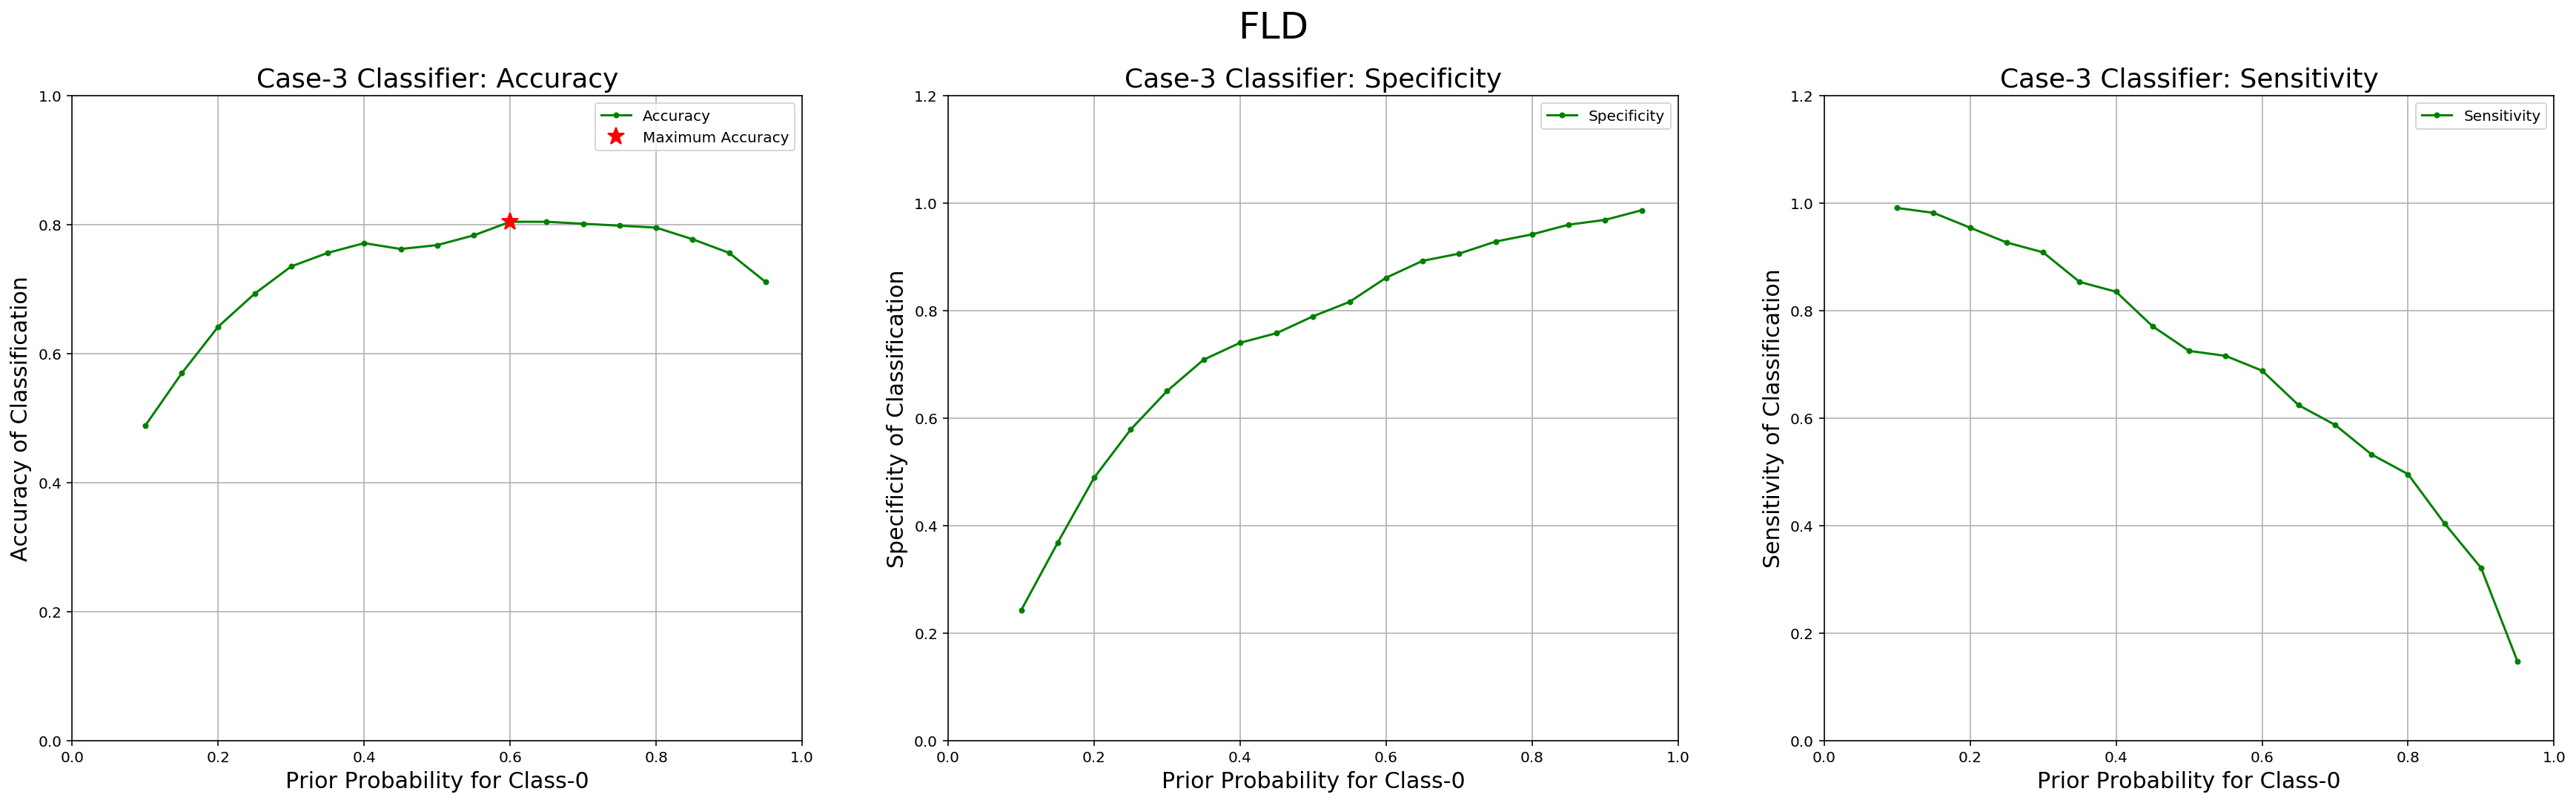

In [812]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_case3=[]
specif_case3=[]
sensit_case3=[]
pri=np.arange(0.1, 1., 0.05)
for prior in pri:
    boolcase3=g0(fXtest, prior)<=g1(fXtest, 1.0-prior) # True if the sample belongs to class-0, False otherwise
    boolcase3=np.array([1 if i else 0 for i in boolcase3])  # Converting the True to zero and False to 1.

#-----------------------------------Accuracy Calculation for Case-3------------------------------------------------------
    testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.    
    accu_case3=testbool+boolcase3
    unique3, counts3 = np.unique(accu_case3, return_counts=True)
    case3=dict(zip(unique3, counts3))
    accuracy_case3= (counts3[0]+counts3[2])/(counts3[0]+counts3[1]+counts3[2])
    perfo_case3.append(accuracy_case3)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------    
    accu_case3_neg=testbool-boolcase3
    tes=zip(accu_case3, accu_case3_neg)
    
    TP3=0
    TN3=0
    FP3=0
    FN3=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TP3=TP3+1
        if plus==0 and minus==0:
            TN3=TN3+1
        if plus==1 and minus==-1:
            FP3=FP3+1
        if plus==1 and minus==1:
            FN3=FN3+1    
    specif_case3.append(TN3/(TN3+FP3))
    sensit_case3.append(TP3/(TP3+FN3))
    
    
plt.figure(1)
plt.figure(figsize=(30,8))
plt.suptitle("FLD", fontsize=25)

plt.subplot(131)
plt.plot(pri, perfo_case3,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_case3)], np.max(perfo_case3),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('Case-3 Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_case3,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_case3)], np.max(specif_case3),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('Case-3 Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_case3,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_case3)], np.max(sensit_case3),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('Case-3 Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()

## Performance KNN

<Figure size 432x288 with 0 Axes>

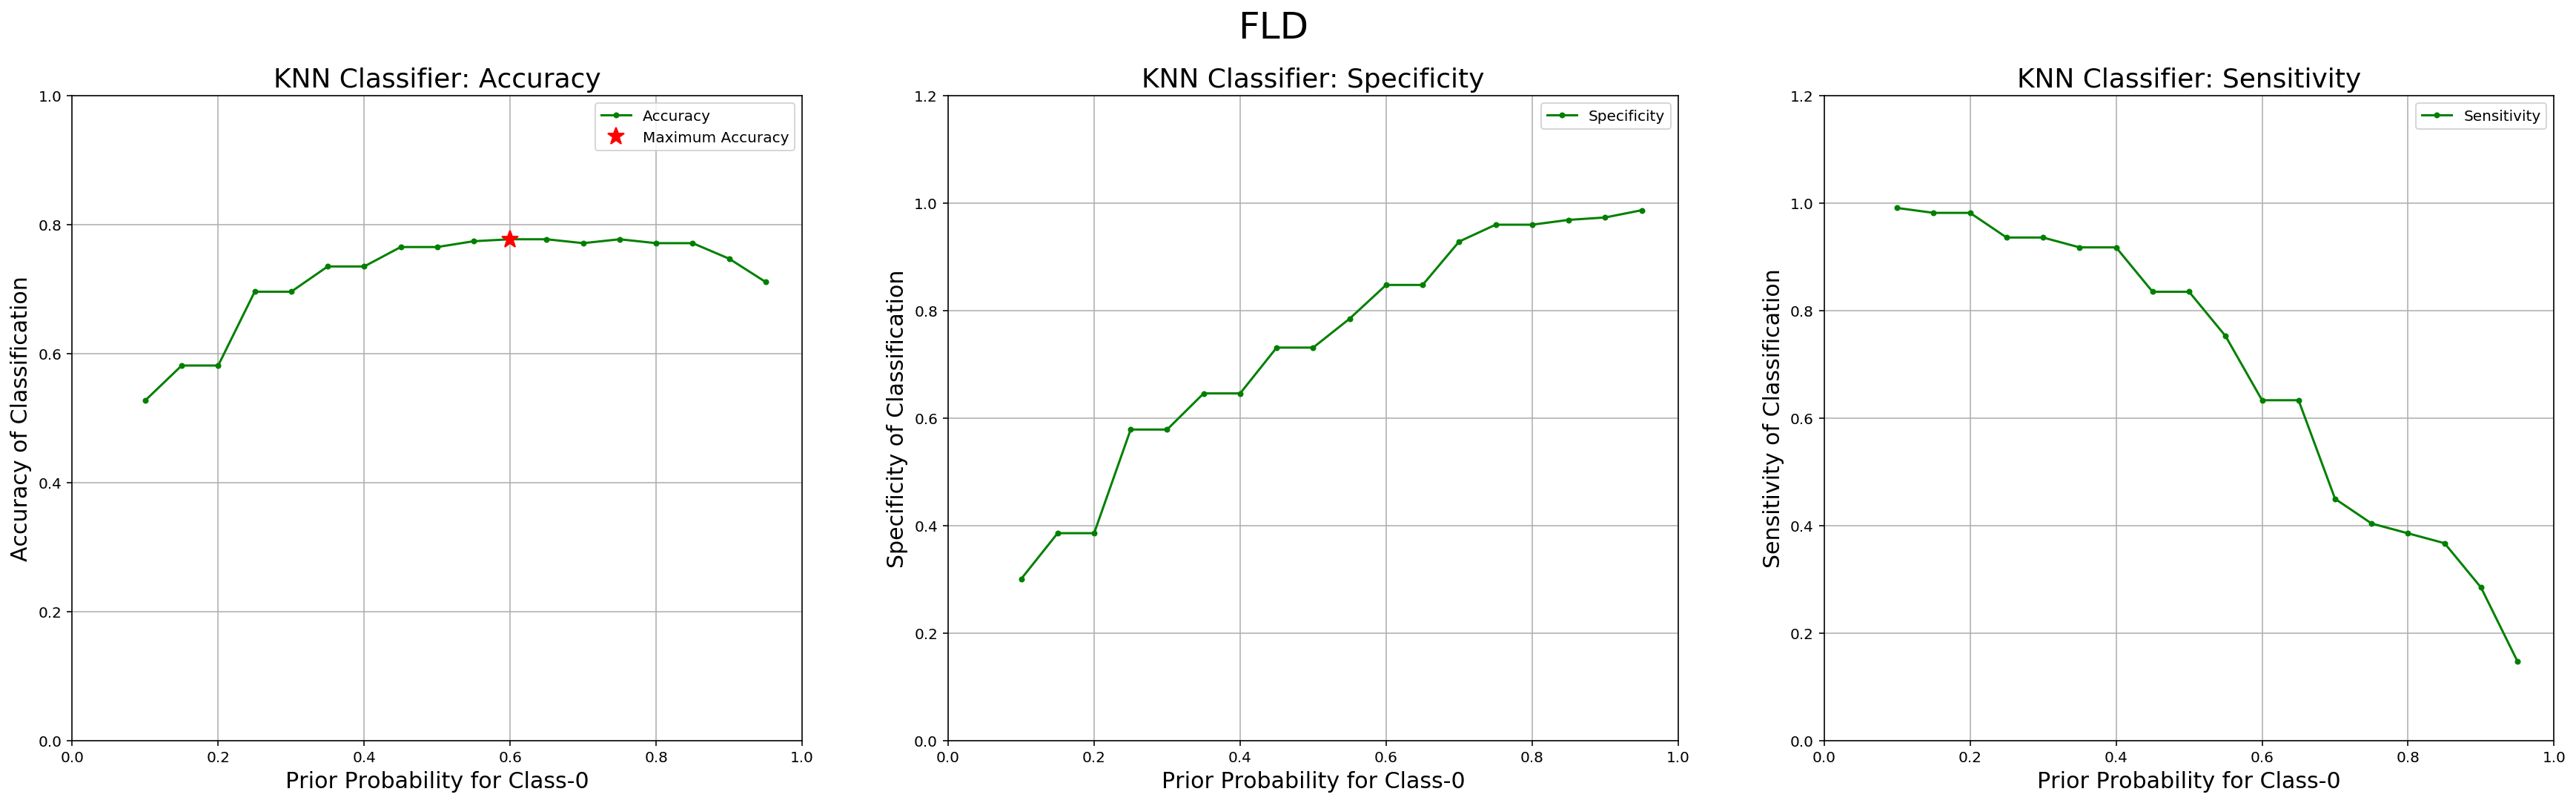

In [814]:
P0=np.arange(0.1, 1., 0.05)  # Prior values for class 0
P1=1-P0                        # Prior values for class 1
alpha0=P0/0.66                 # Alpha values for class 0
alpha1=P1/0.34                 # Alpha values for class 1

#-----------------------------------Accuracy Calculation for KNN------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

#------------------------------------Accuracy as a function of prior values------------------------------------------------
perfo_KNN=[]
specif_KNN=[]
sensit_KNN=[]

for i in range(len(alpha0)):
    accu_KNN=testbool+KNNbool(14, alpha0[i],  alpha1[i]) # K=14, alpha0 and alpha 1
    uniqueK, countsK = np.unique(accu_KNN, return_counts=True)
    caseK=dict(zip(uniqueK, countsK))
    accuracy_KNN= (countsK[0]+countsK[2])/(countsK[0]+countsK[1]+countsK[2])
    perfo_KNN.append(accuracy_KNN)
    
#-------------------------------Sensitivity and Specificity calculation-------------------------------------------  
    accu_KNN_neg=testbool-KNNbool(14, alpha0[i],  alpha1[i])
    tes=zip(accu_KNN, accu_KNN_neg)

    TPK=0
    TNK=0
    FPK=0
    FNK=0
    for plus, minus in tes:
        if plus==2 and minus==0:
            TPK=TPK+1
        if plus==0 and minus==0:
            TNK=TNK+1
        if plus==1 and minus==-1:
            FPK=FPK+1
        if plus==1 and minus==1:
            FNK=FNK+1    
    specif_KNN.append(TNK/(TNK+FPK))
    sensit_KNN.append(TPK/(TPK+FNK))

plt.figure(1)
plt.figure(figsize=(30,8))
plt.suptitle("FLD", fontsize=25)

plt.subplot(131)
plt.plot(pri, perfo_KNN,'g.-', label='Accuracy')
plt.plot(pri[np.argmax(perfo_KNN)], np.max(perfo_KNN),'r*', label='Maximum Accuracy', markersize=12)
plt.ylim(0,1.)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Accuracy of Classification', fontsize=15)
plt.title('KNN Classifier: Accuracy', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(132)
plt.plot(pri, specif_KNN,'g.-', label='Specificity')
# plt.plot(pri[np.argmax(specif_KNN)], np.max(specif_KNN),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Specificity of Classification', fontsize=15)
plt.title('KNN Classifier: Specificity', fontsize=18)
plt.legend(loc='upper right')

plt.subplot(133)
plt.plot(pri, sensit_KNN,'g.-', label='Sensitivity')
# plt.plot(pri[np.argmax(sensit_KNN)], np.max(sensit_KNN),'r*', label='Maximum Specificity', markersize=12)
plt.ylim(0,1.2)
plt.xlim(0,1.)
plt.grid(True)
plt.xlabel('Prior Probability for Class-0', fontsize=15)
plt.ylabel('Sensitivity of Classification', fontsize=15)
plt.title('KNN Classifier: Sensitivity', fontsize=18)
plt.legend(loc='upper right')
plt.show()